In [1]:
import networkx as nx
import pprint as pp
import json
import pylab as pl
import seaborn as sns

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
graphs = []

with open("/Users/anokhin/Desktop/graphs.txt", "r") as gf:
    for i, line in enumerate(gf):
        graph = nx.MultiGraph()
        
        js = json.loads(line)
        for ed in js["value"].get("edges", []):                
            v1 = ed.get("vertex1")
            if v1 is None:
                raise ValueError("vertex1 not found JSON!")
            if v1 not in graph:
                graph.add_node(v1["uid"], uid_type=v1["uid_type"])           
            
            v2 = ed.get("vertex2")
            if v2 is None:
                raise ValueError("vertex2 not found JSON!")
            if v2 not in graph:
                graph.add_node(v2["uid"], uid_type=v2["uid_type"])
                
            if v1 == v2:
                current_hit_count = graph.node.get(v1["uid"]).get('hit_count', 0)
                graph.add_node(
                    v1["uid"], 
                    uid_type=v2["uid_type"], 
                    hit_count=current_hit_count+ed.get("hit_count", {}).get("int", 0))
            else:
                graph.add_edge(
                    v1["uid"], 
                    v2["uid"], 
                    gender = ed.get("gender").get("boolean") if ed.get("gender") is not None else "-", 
                    age = ed.get("age").get("int") if ed.get("age") is not None else "-", 
                    hit_count = ed.get("hit_count").get("int") if ed.get("hit_count") is not None else "-"
                )
        
        if len(graph.nodes()) > 10:
            graphs.append(graph)      
                
        if i >= 1000:
            break
            
print "Found %d non-trivial graphs" % len(graphs)

Found 64 non-trivial graphs


/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/usr/local/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/usr/local/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':
/usr/local/lib/python2.7/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More

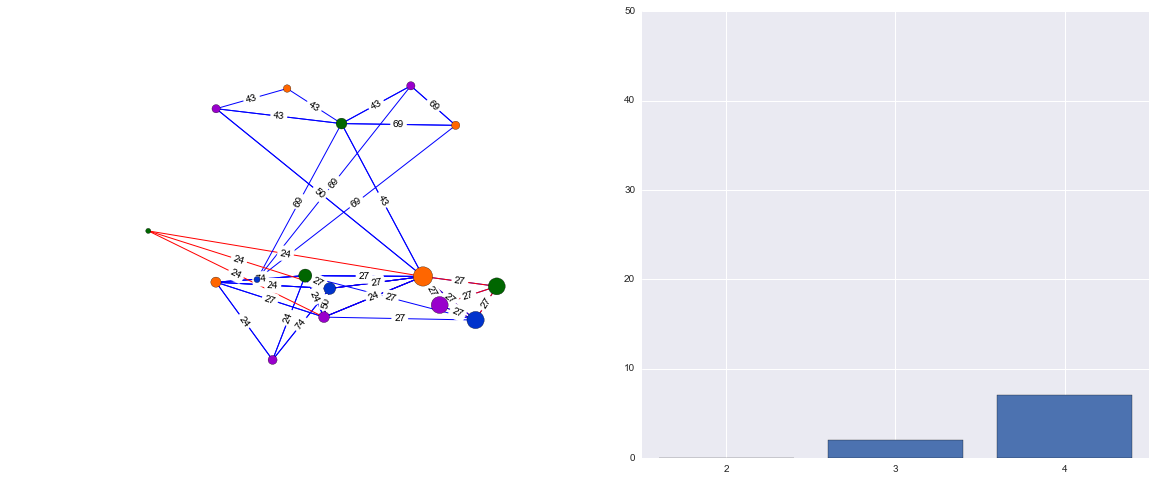

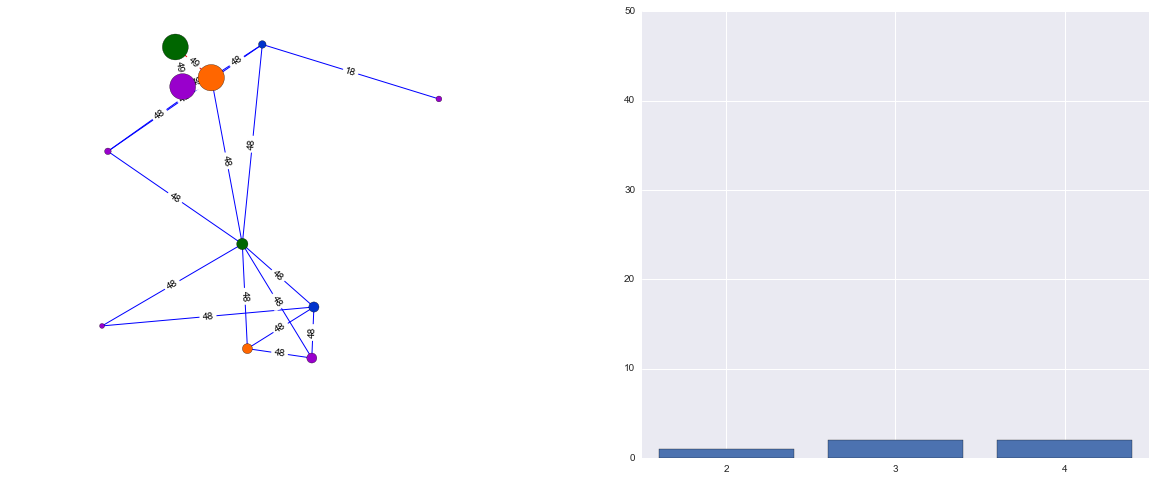

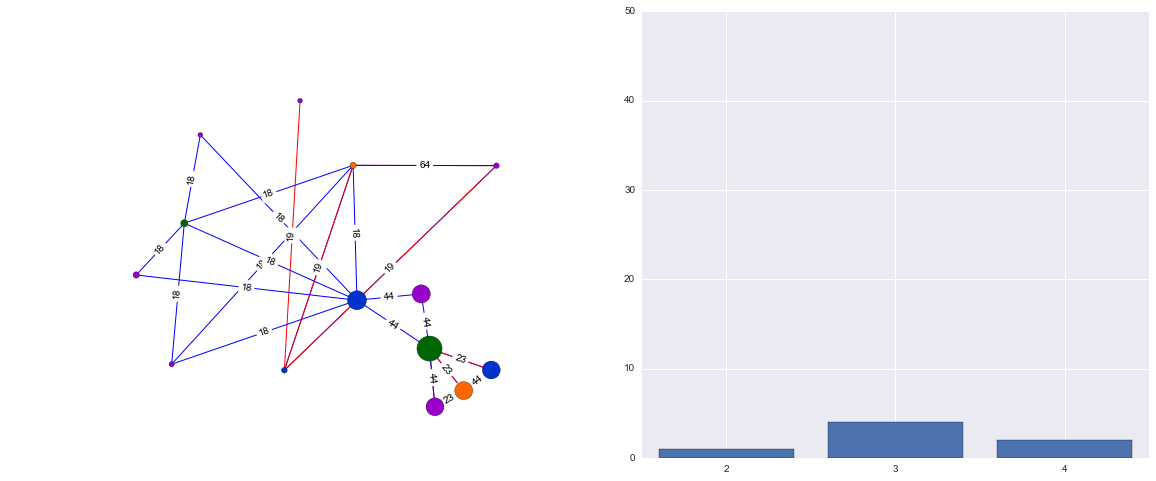

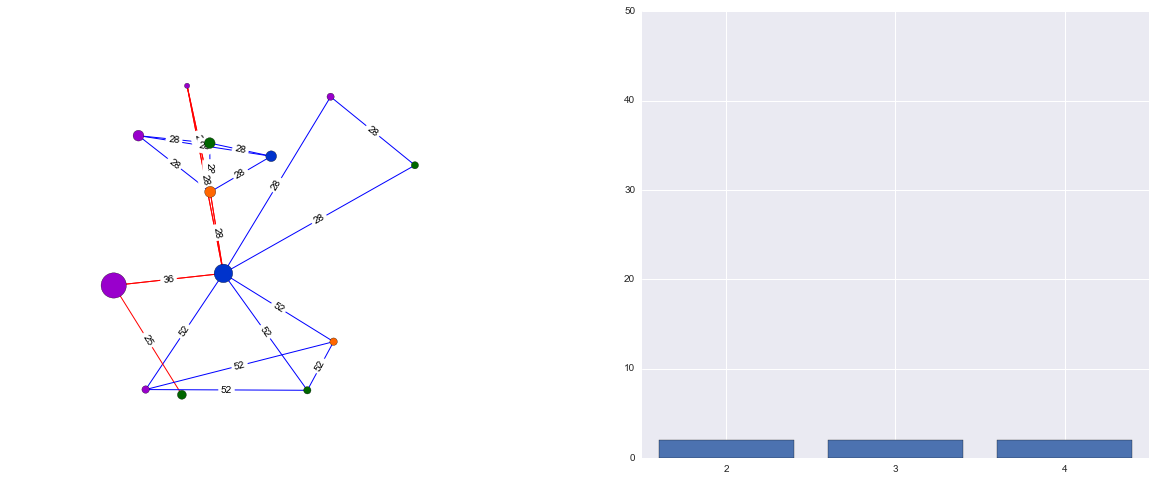

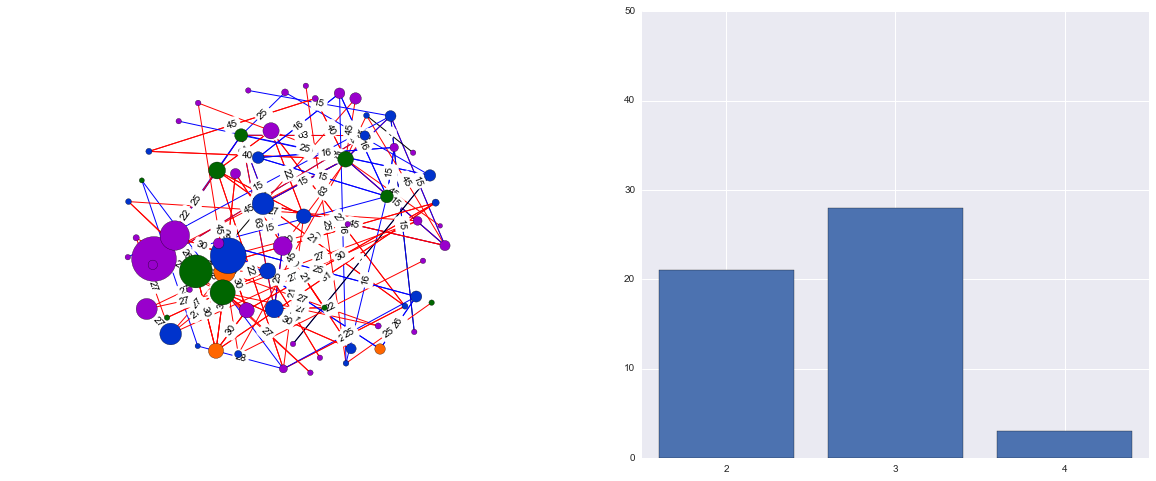

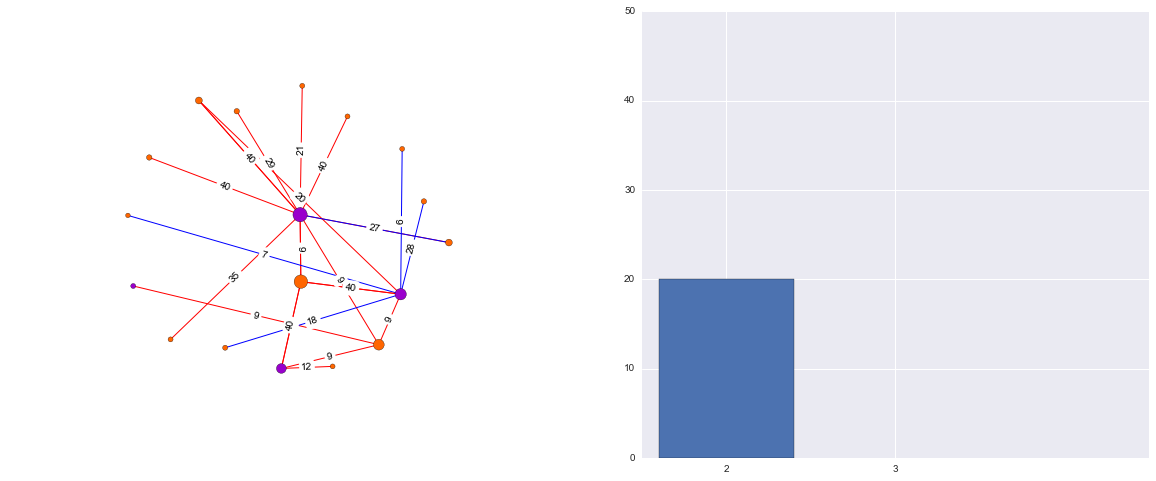

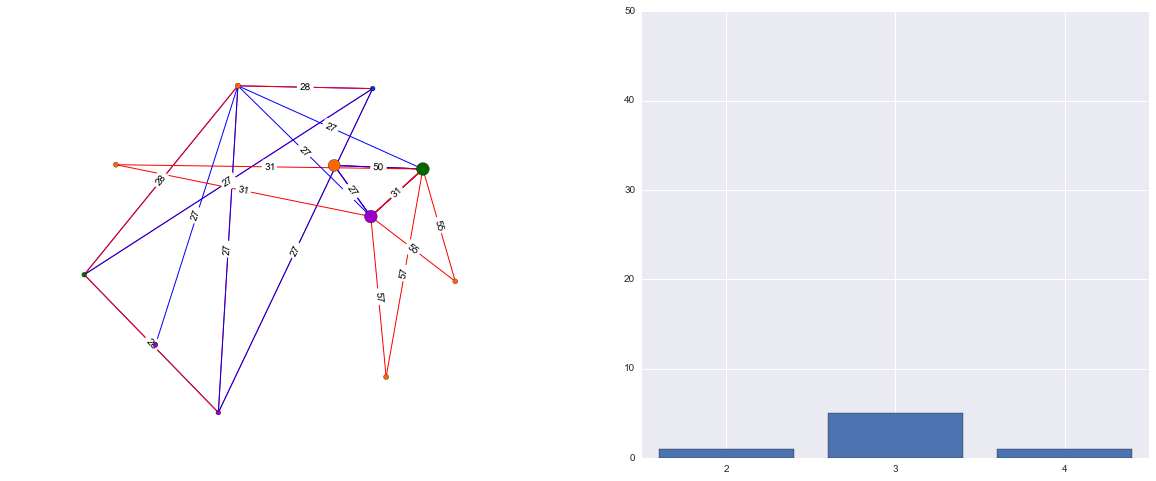

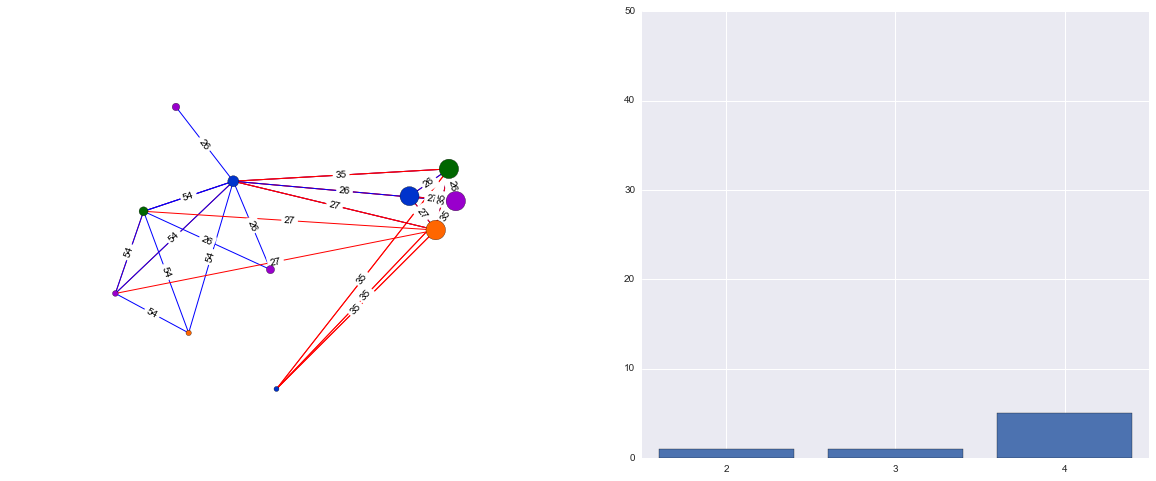

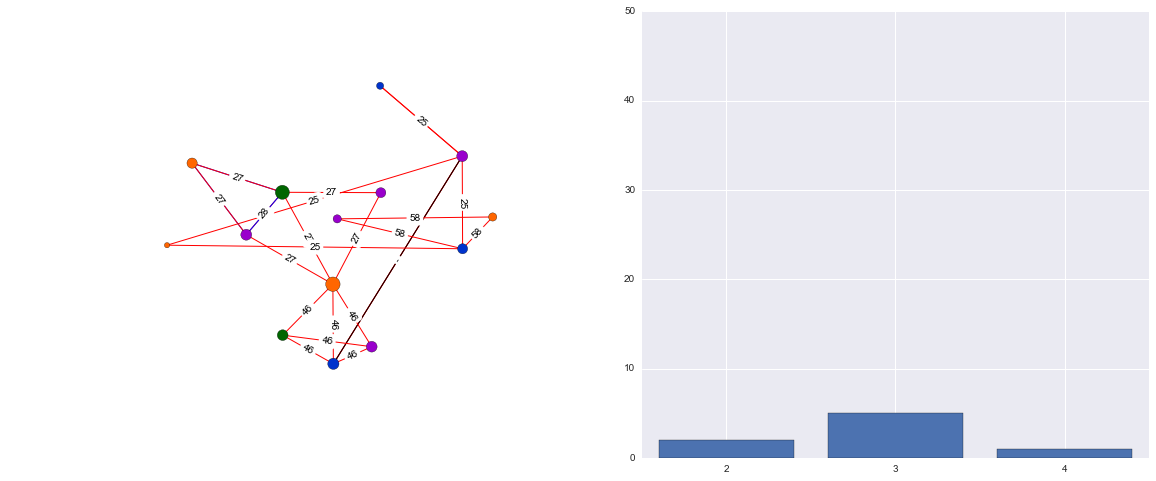

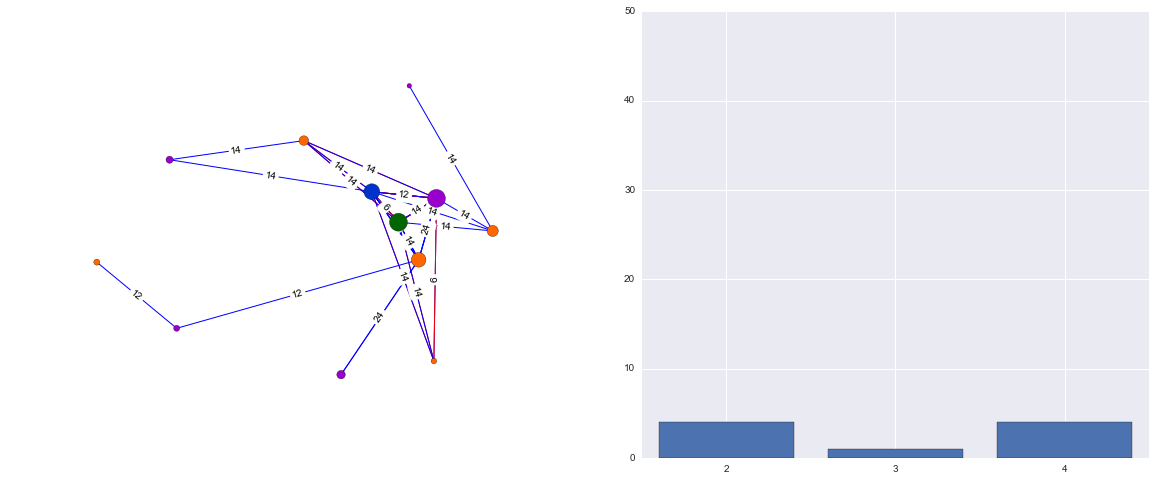

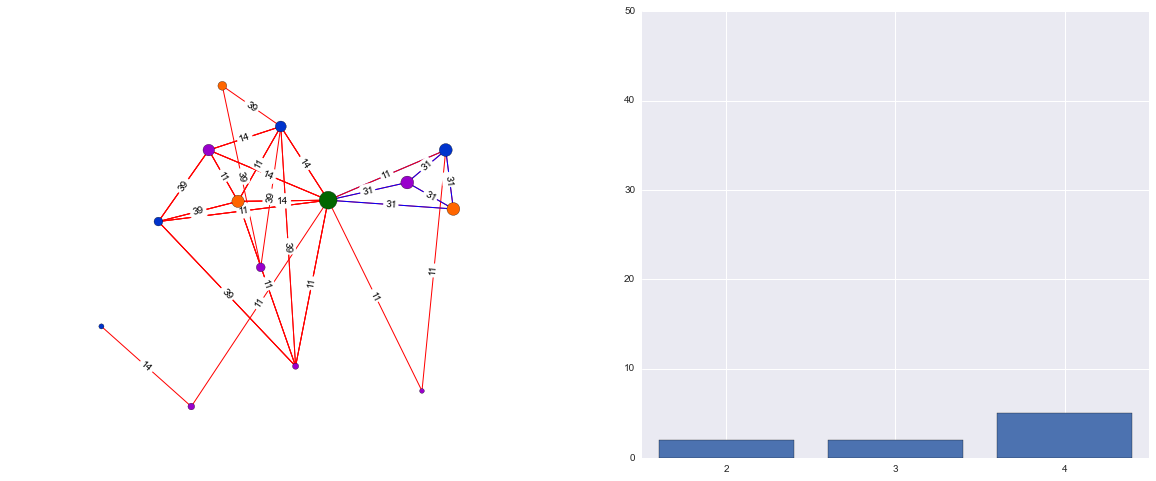

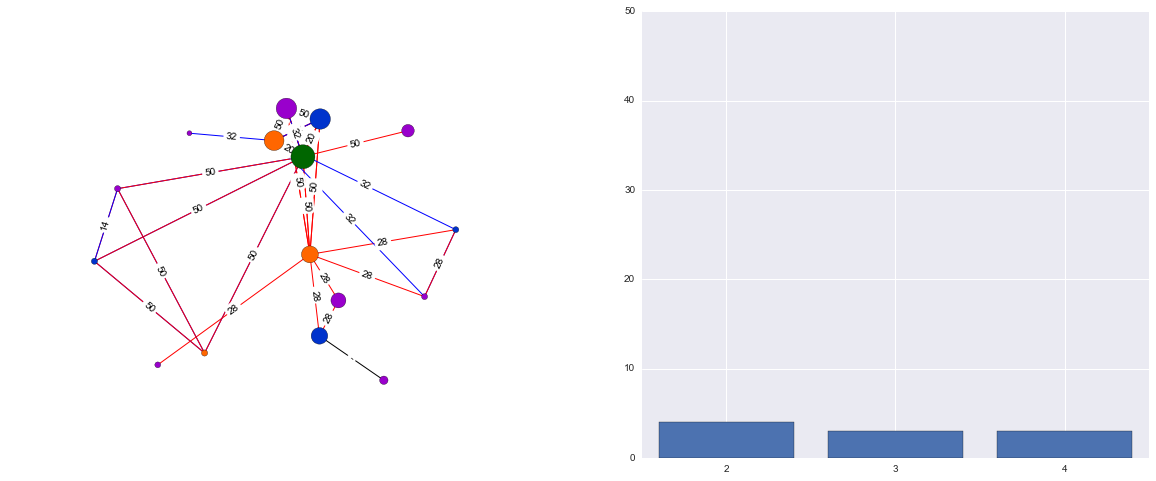

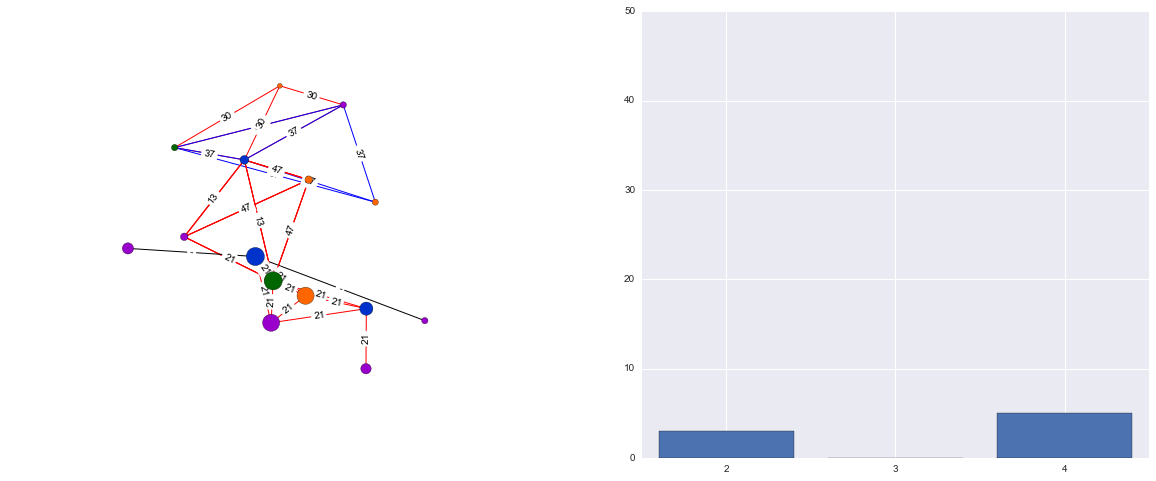

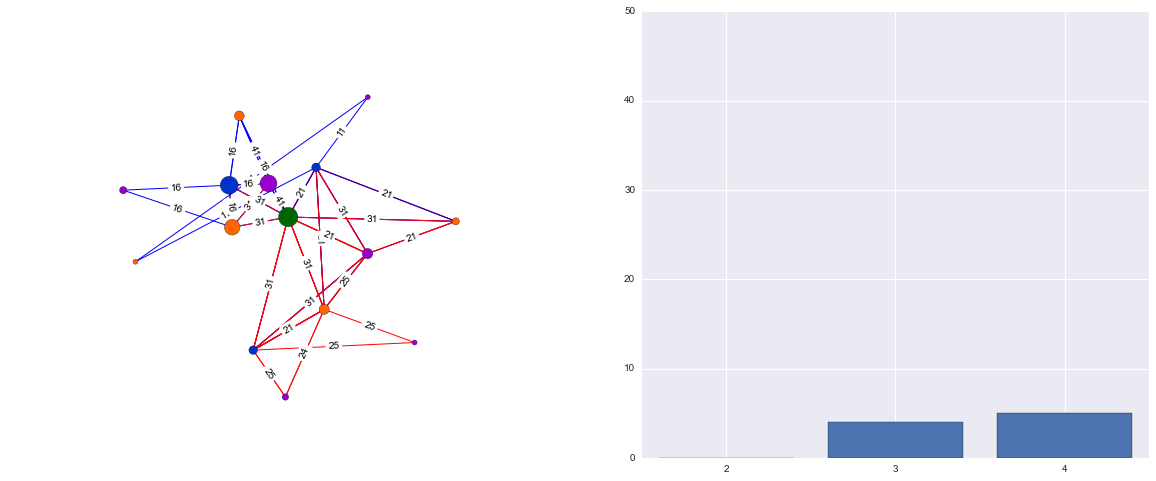

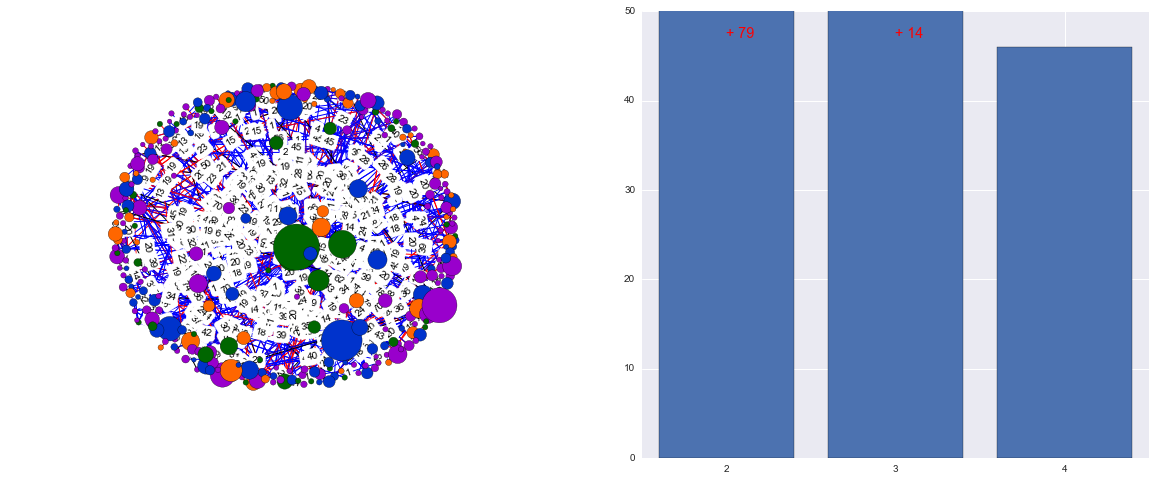

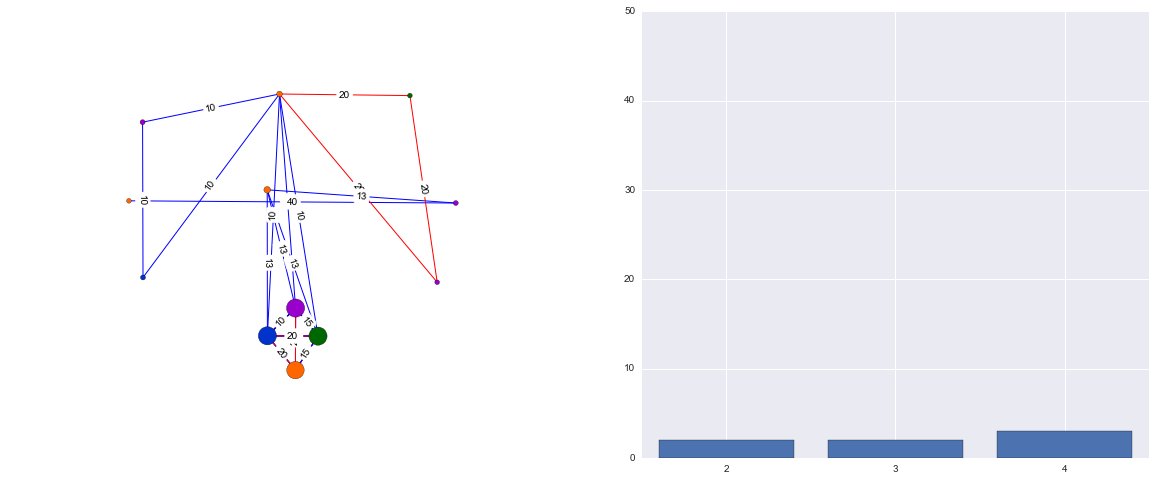

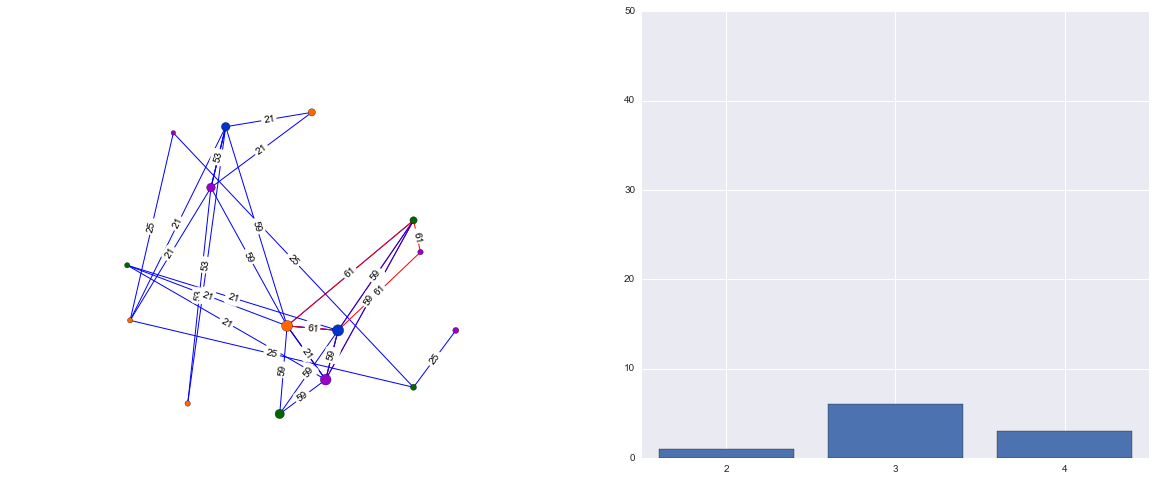

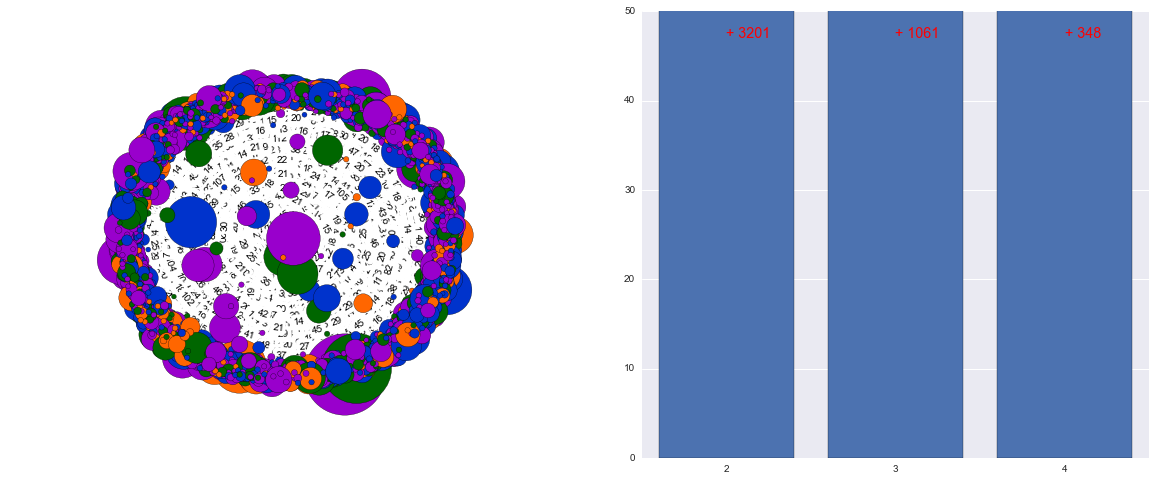

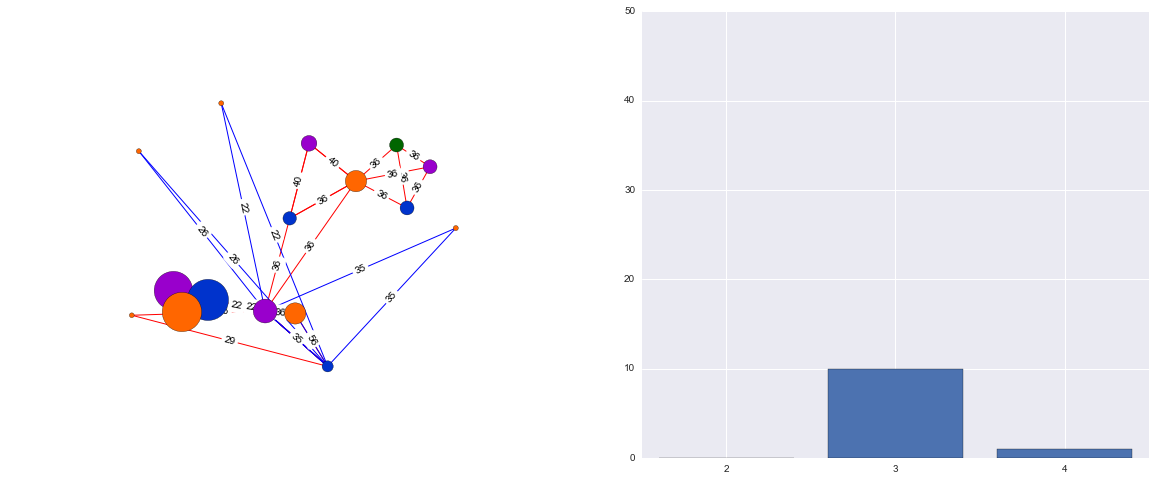

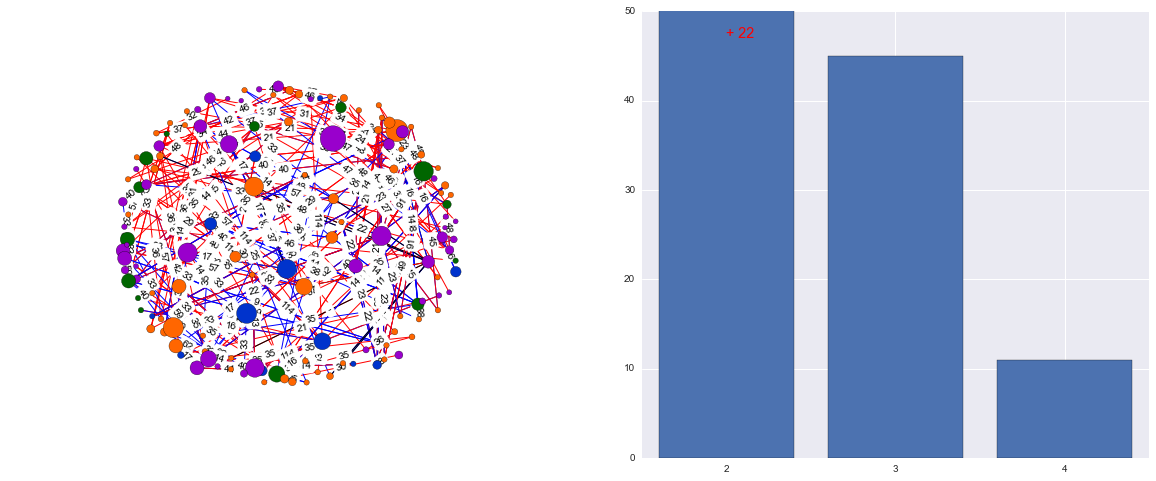

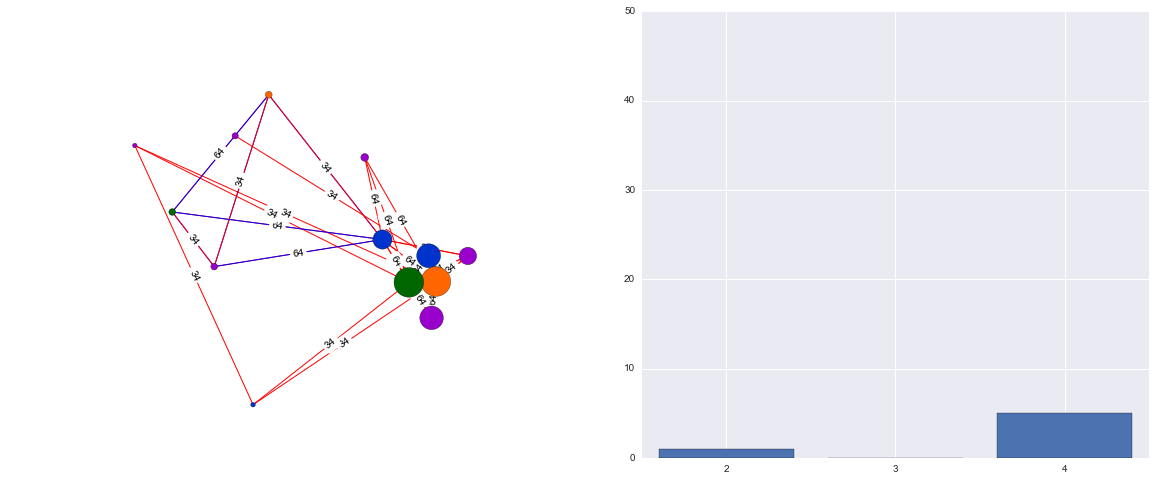

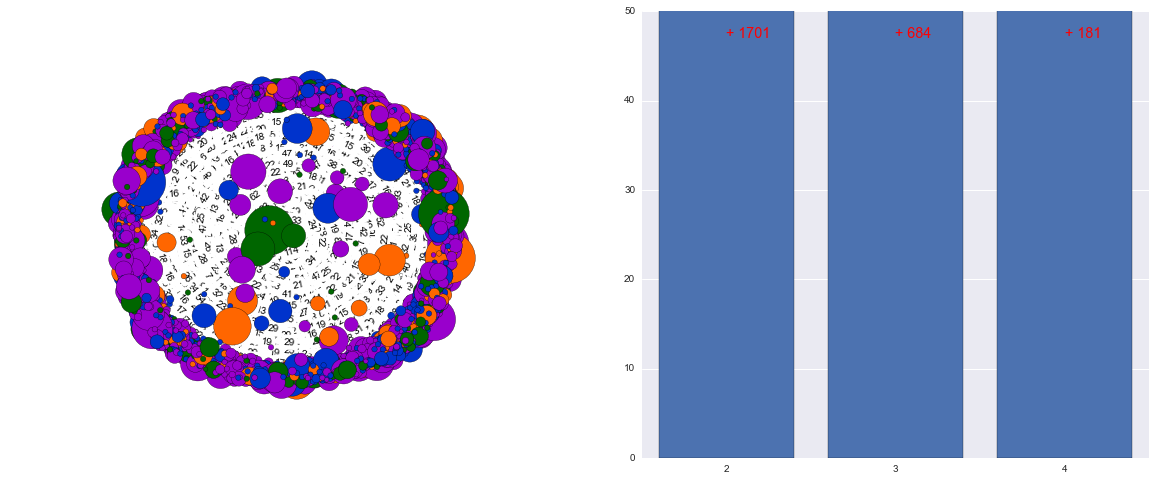

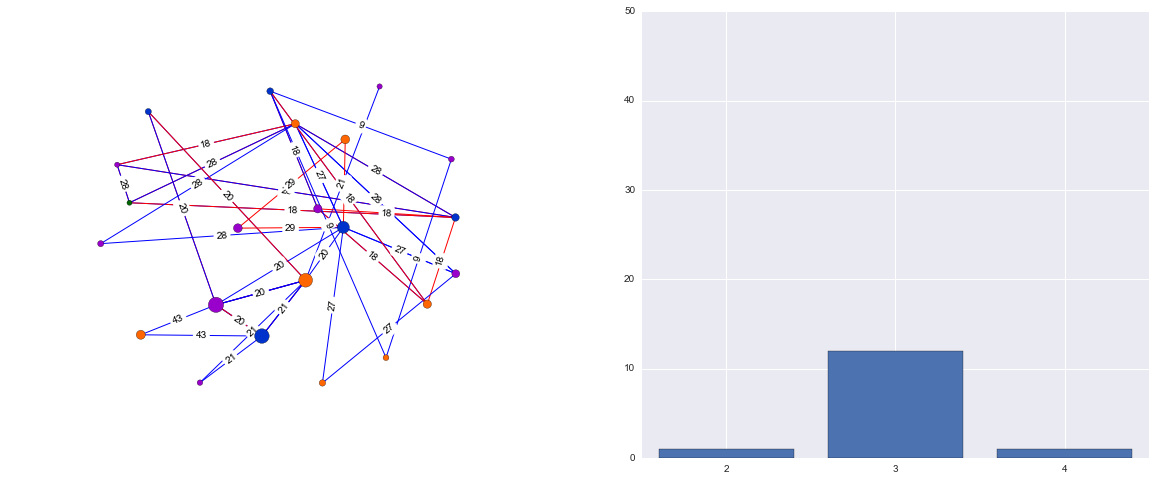

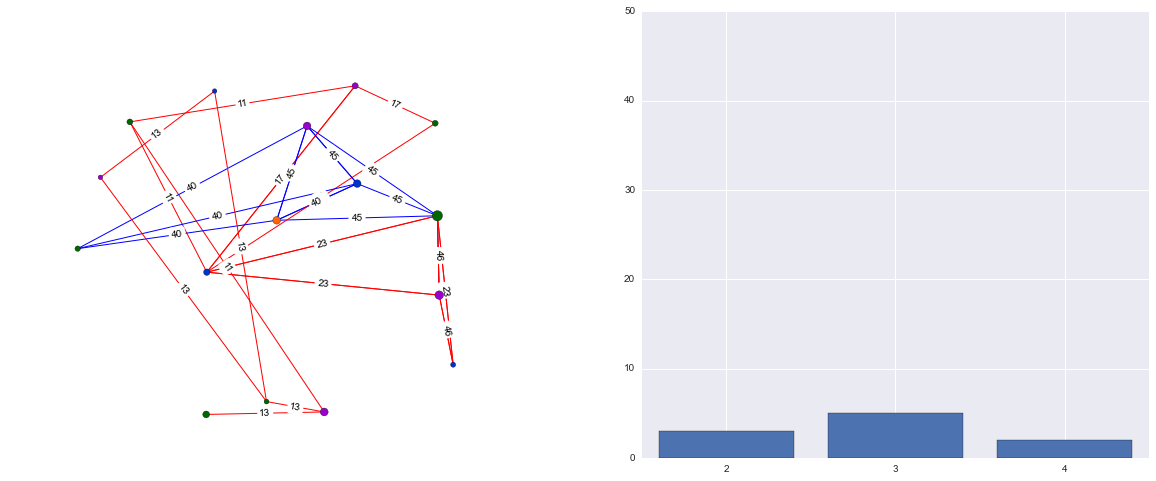

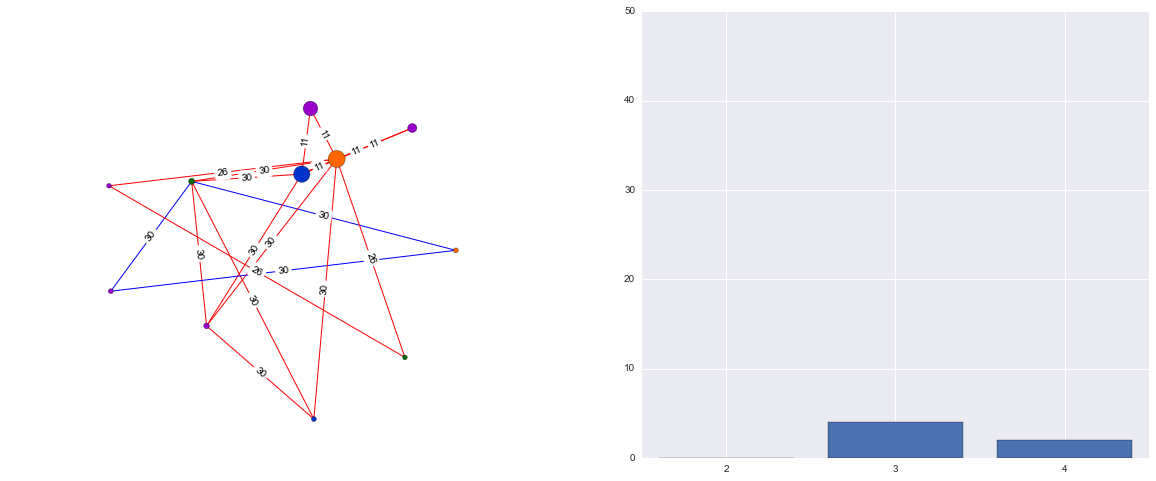

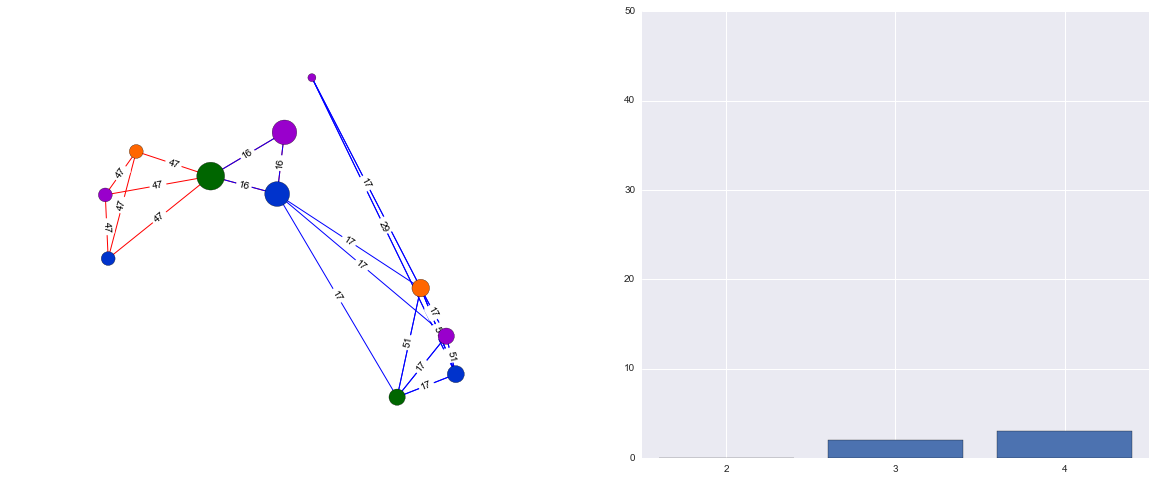

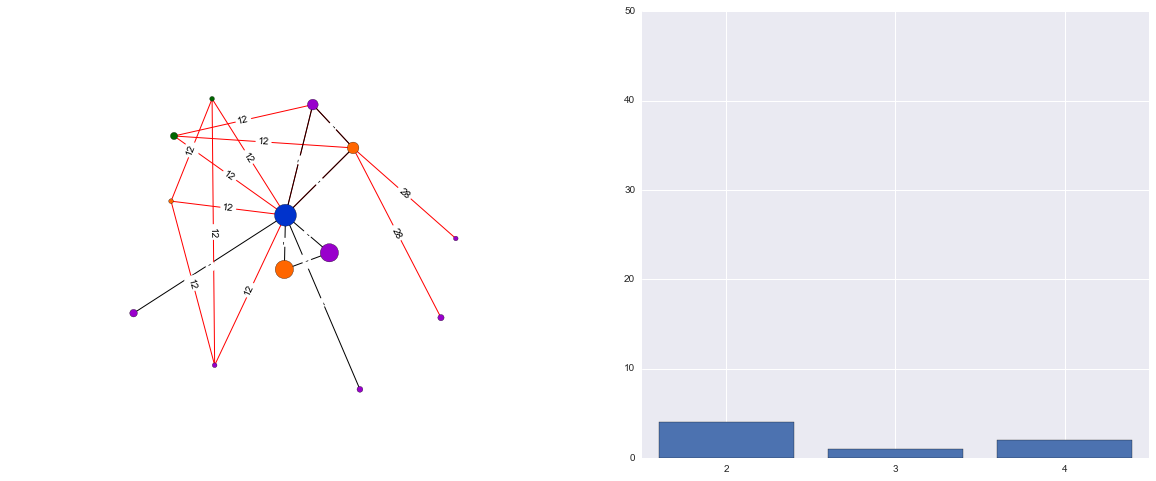

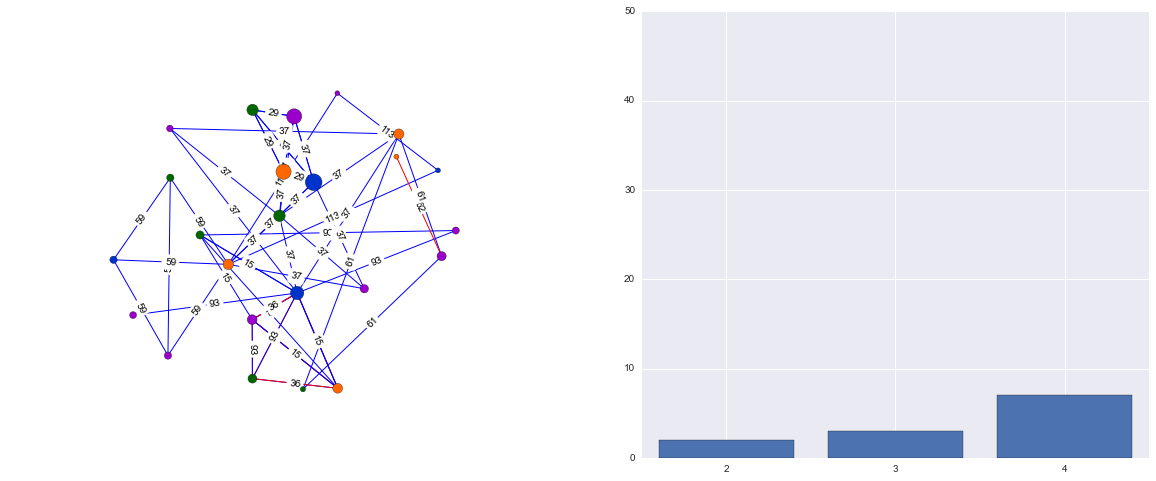

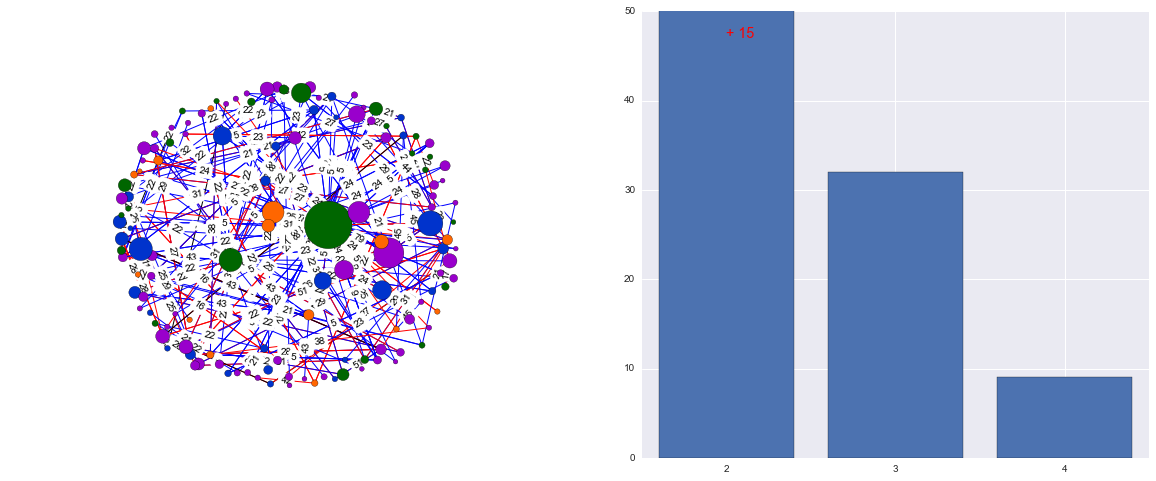

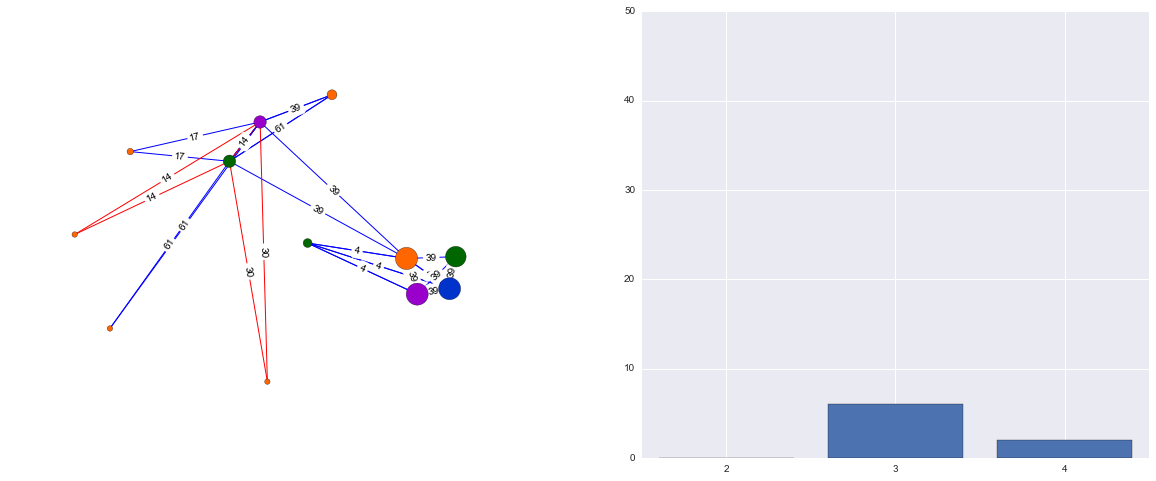

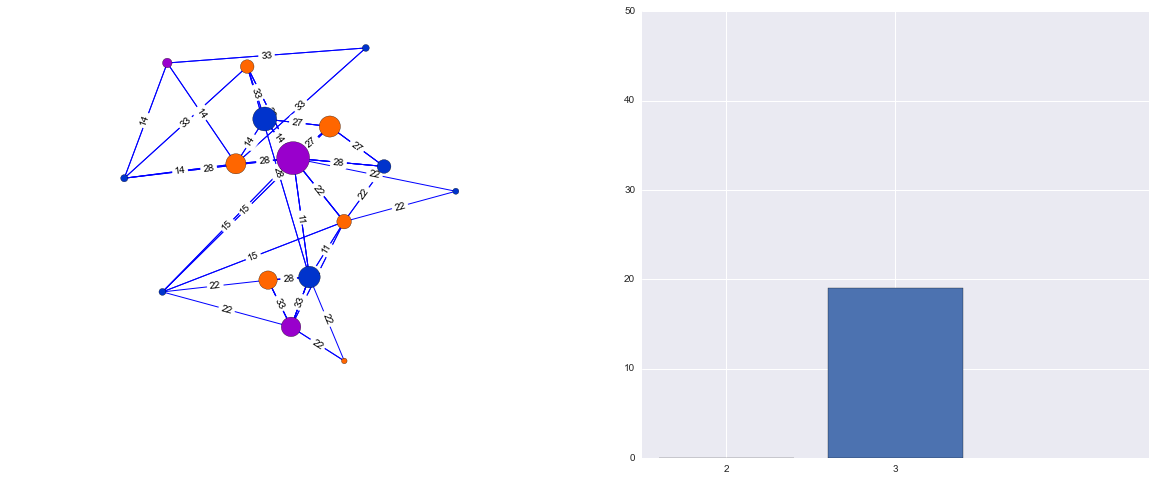

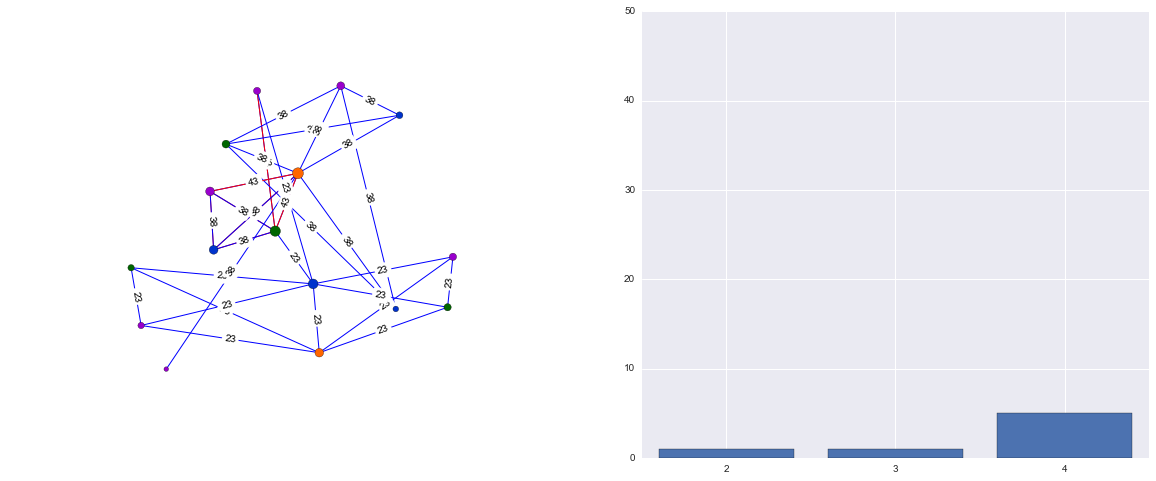

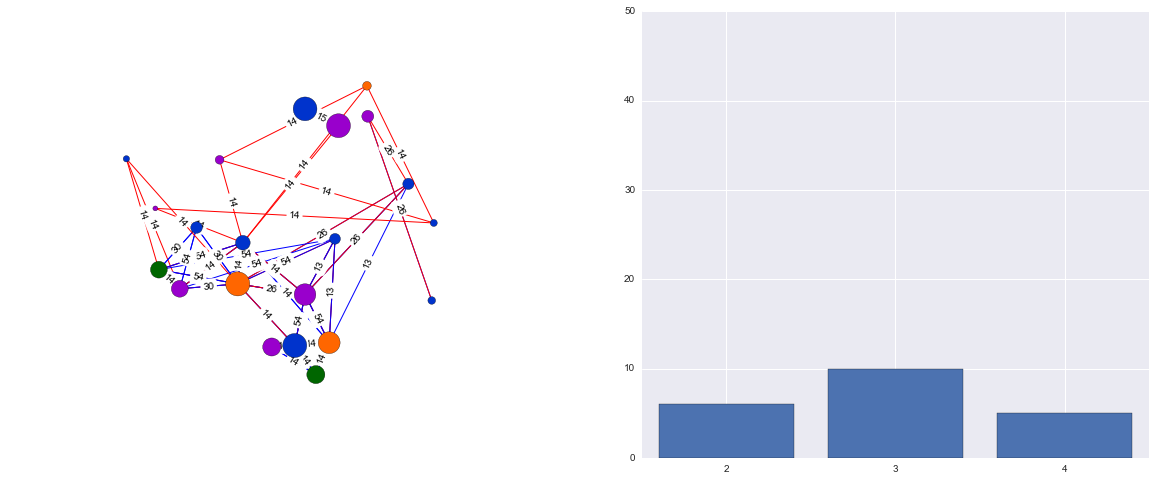

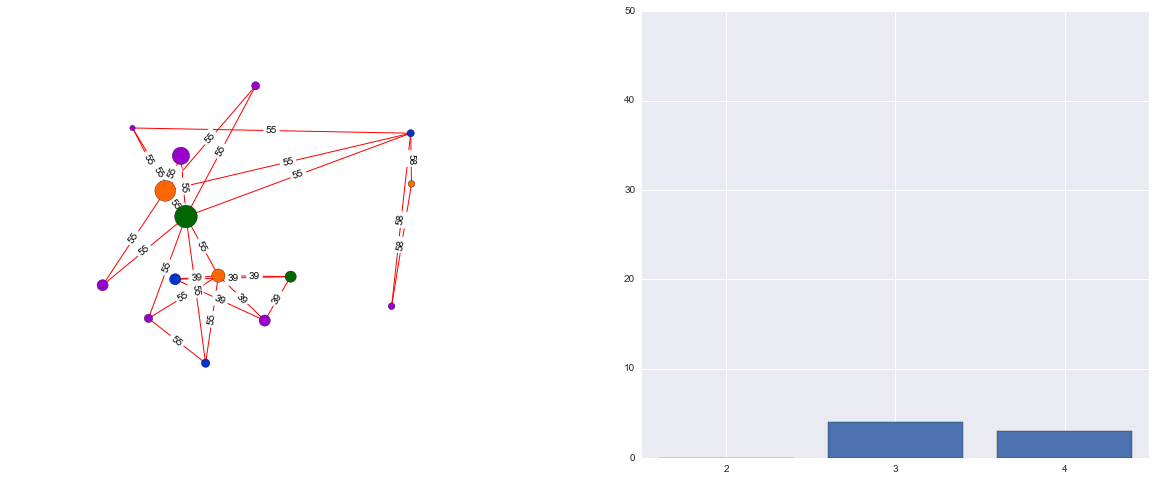

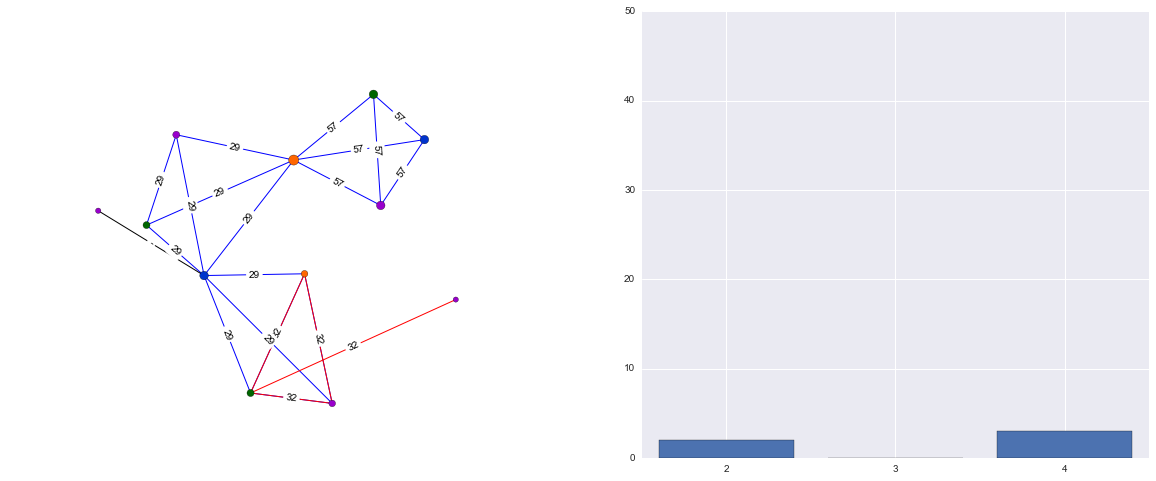

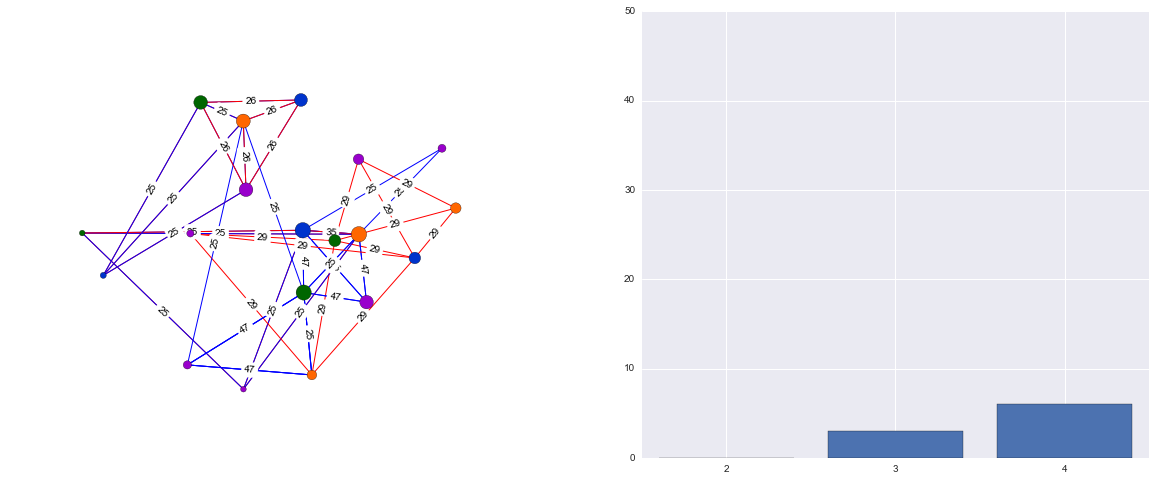

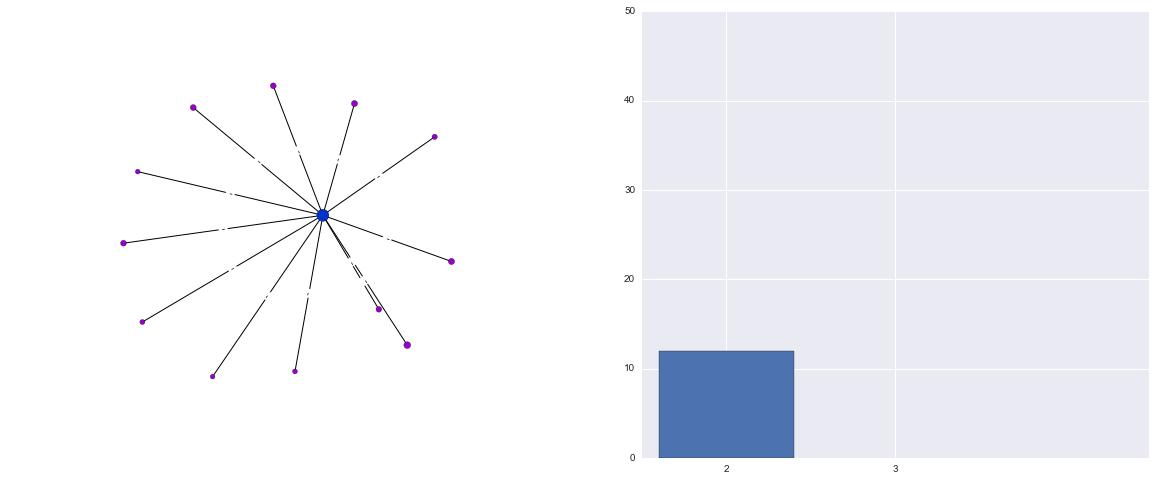

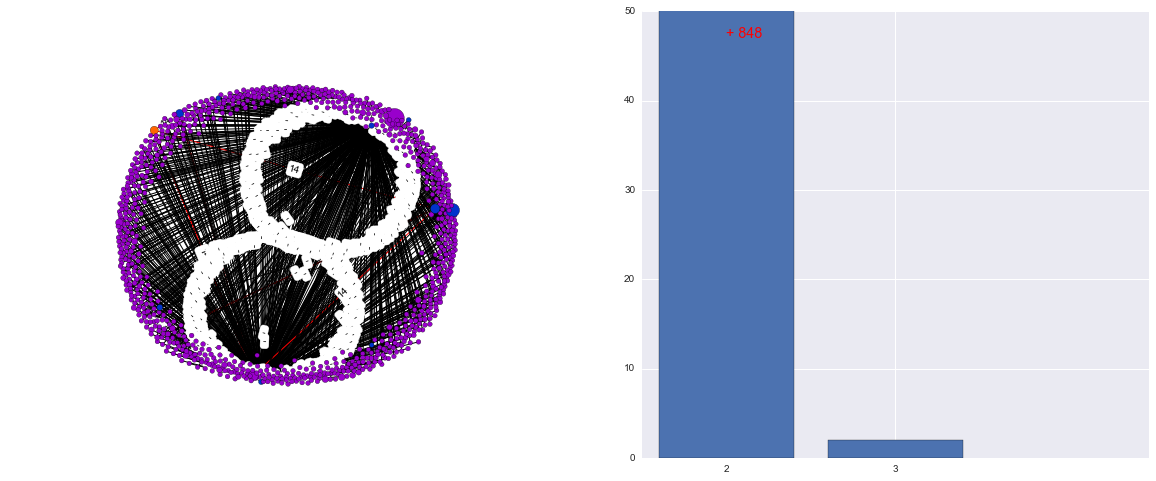

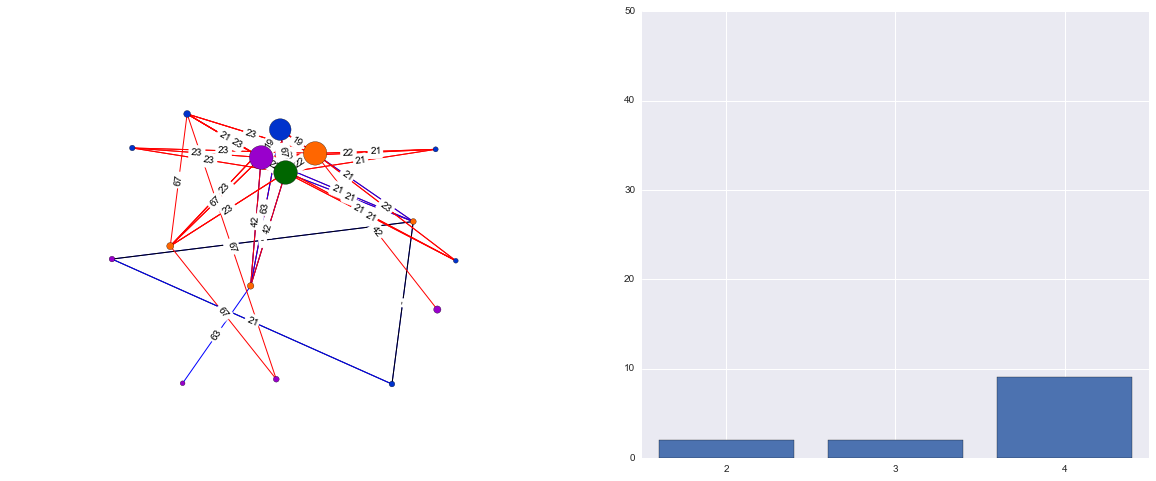

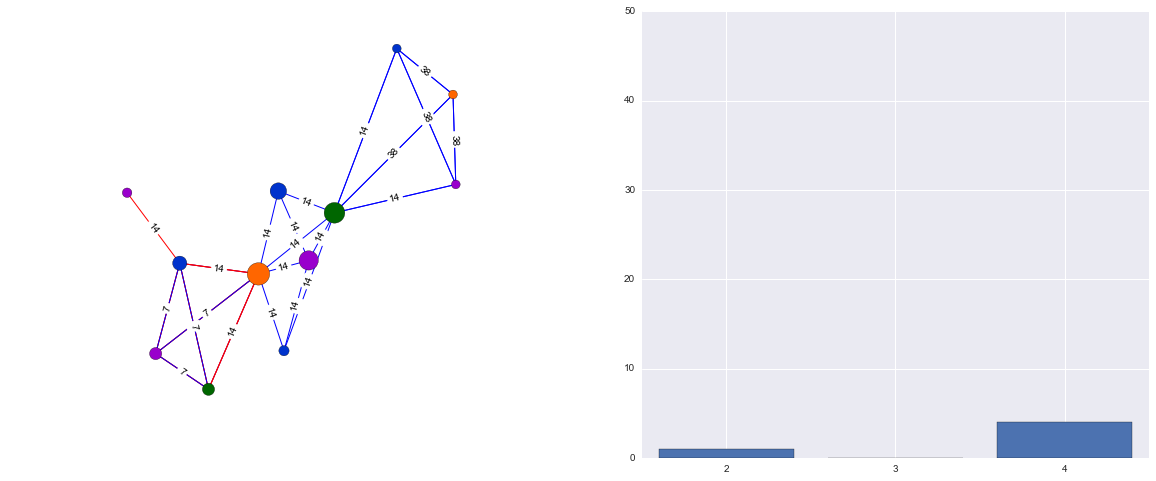

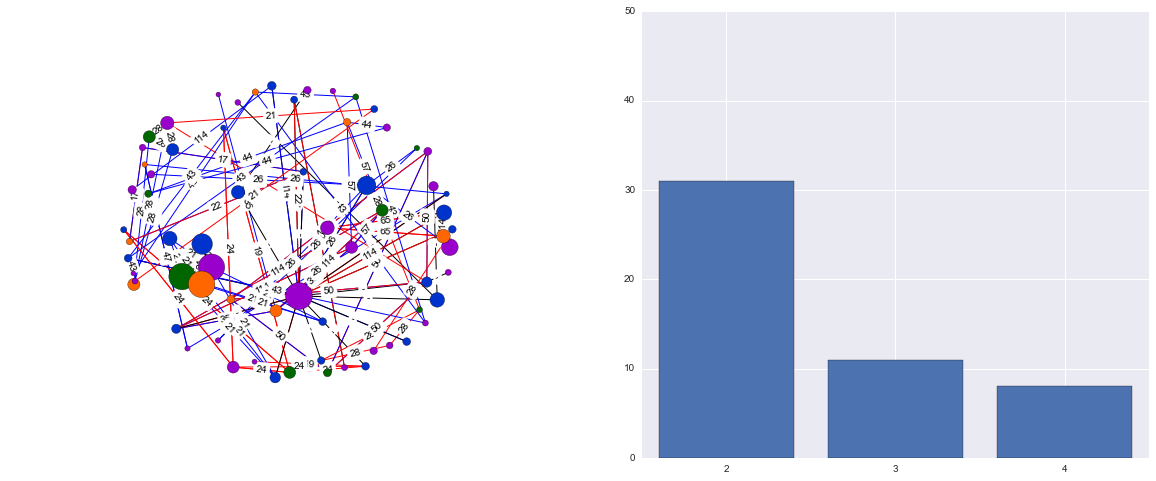

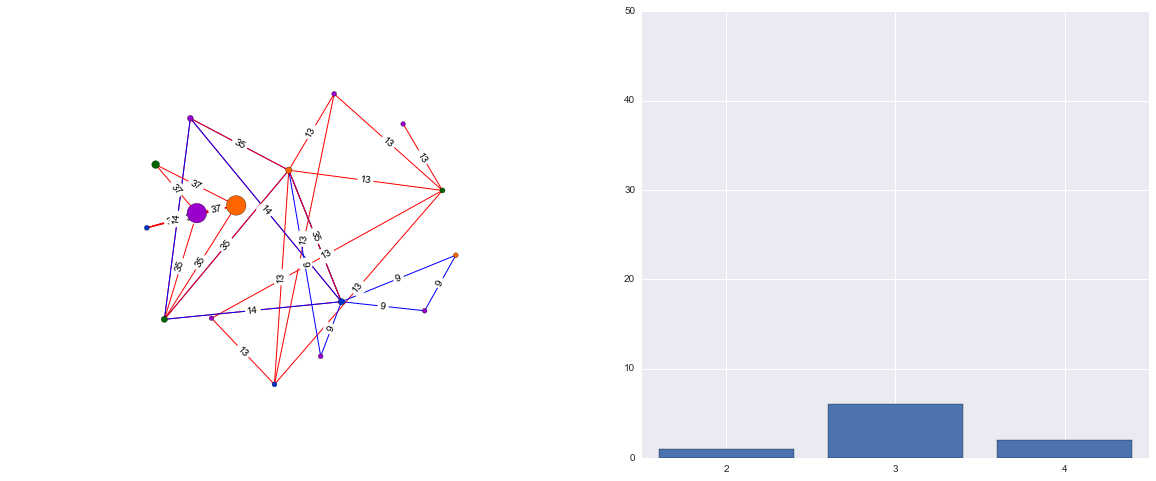

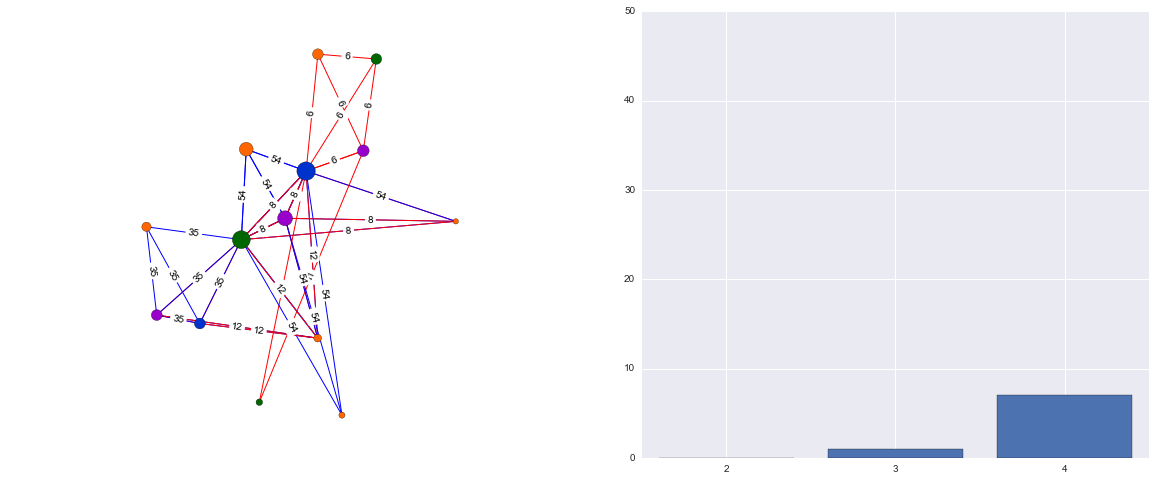

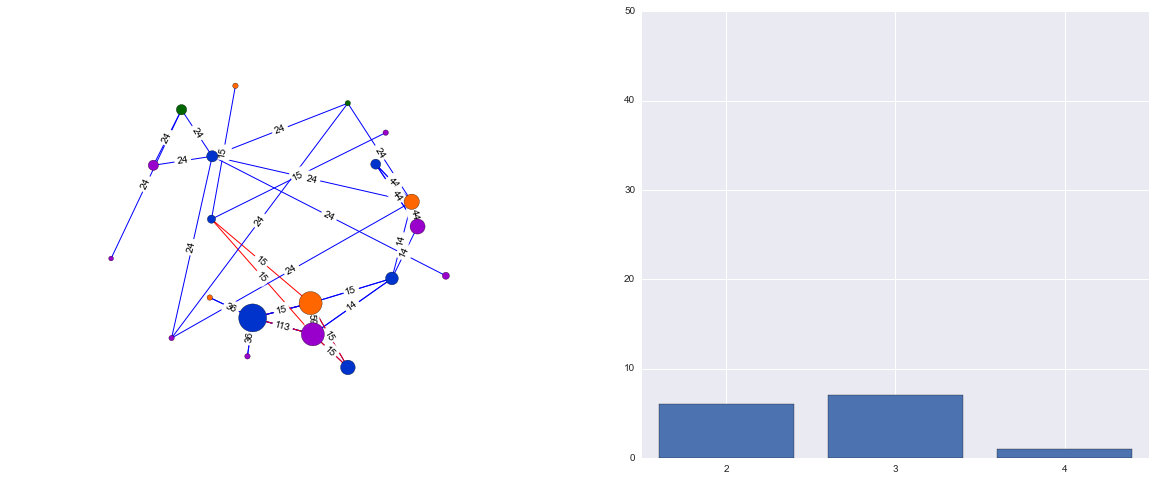

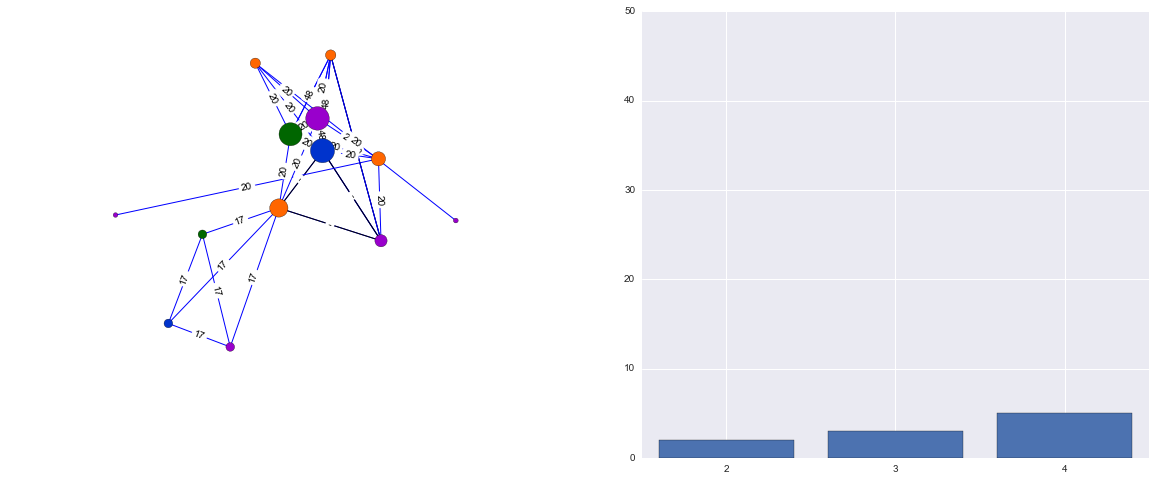

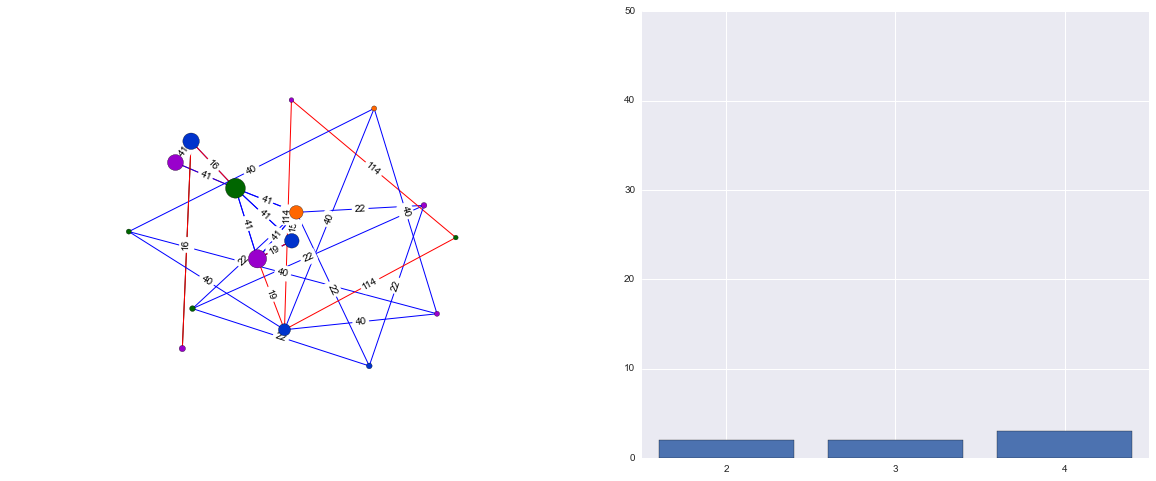

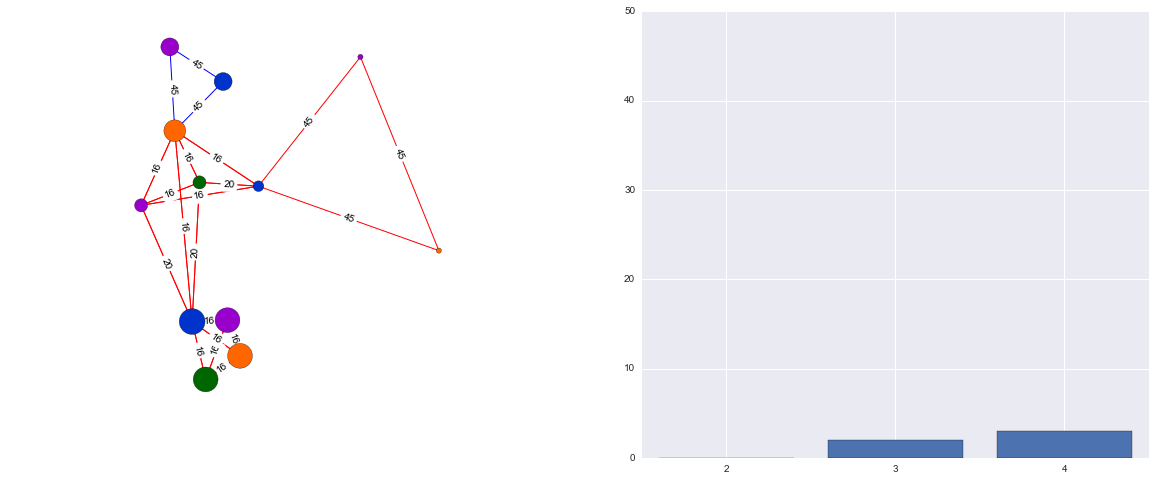

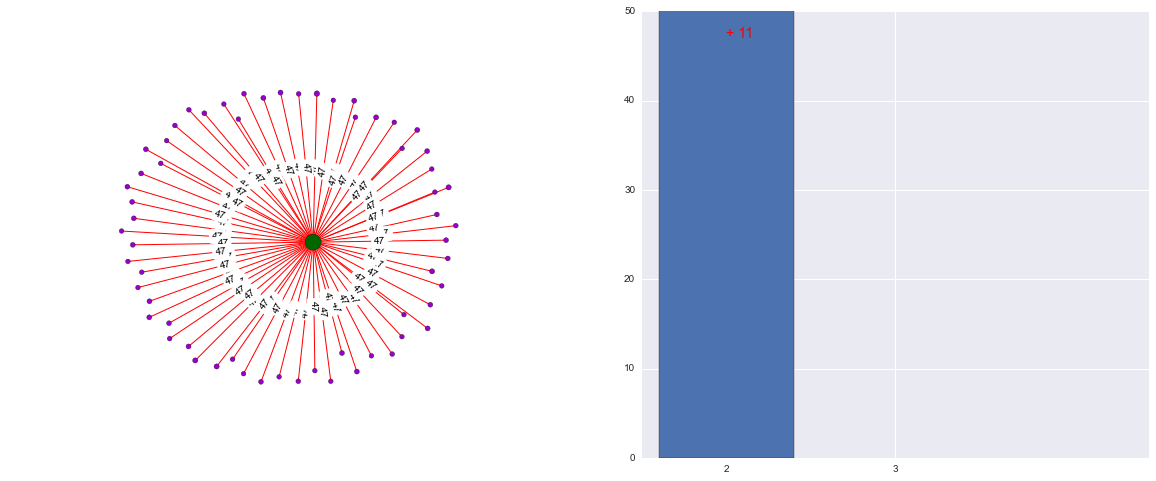

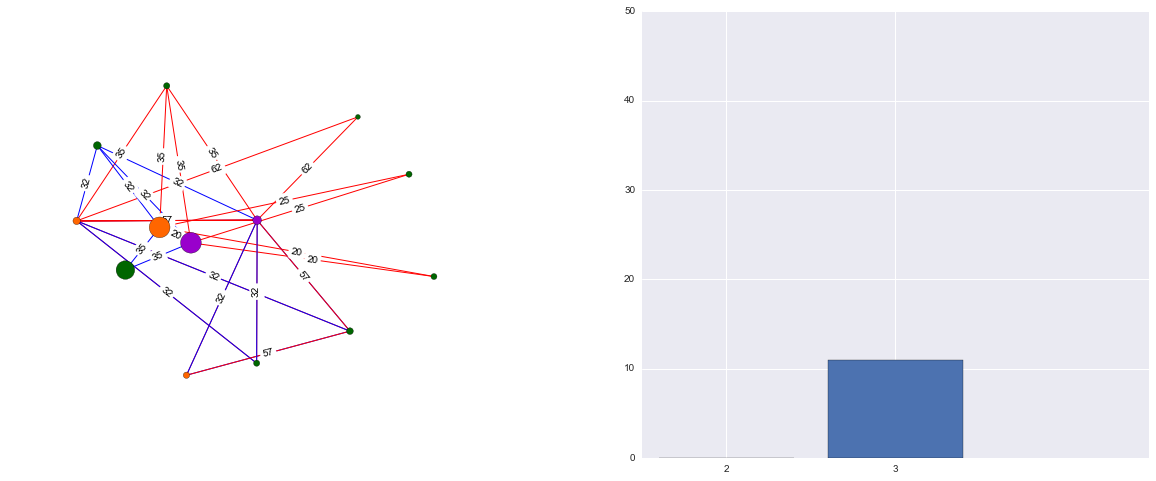

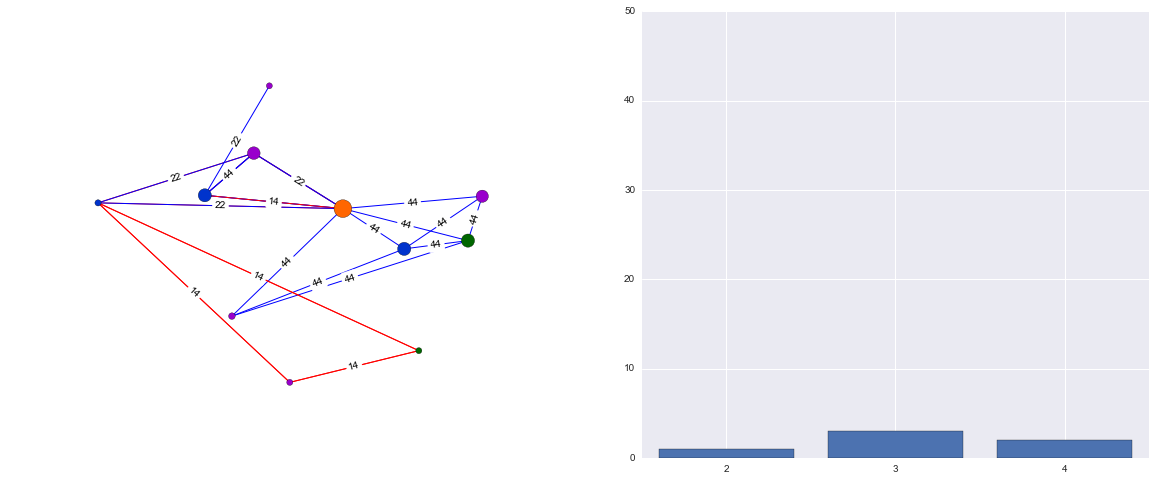

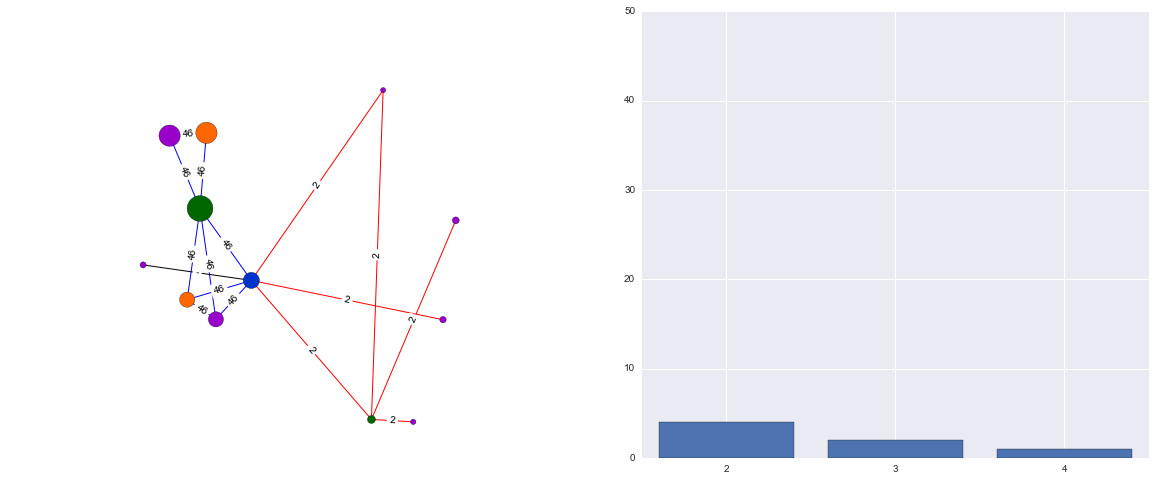

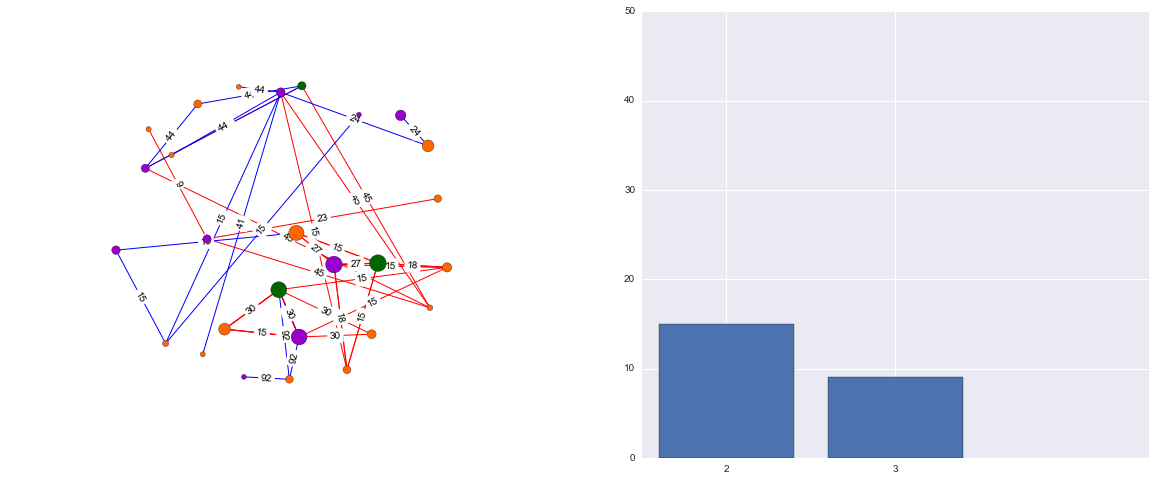

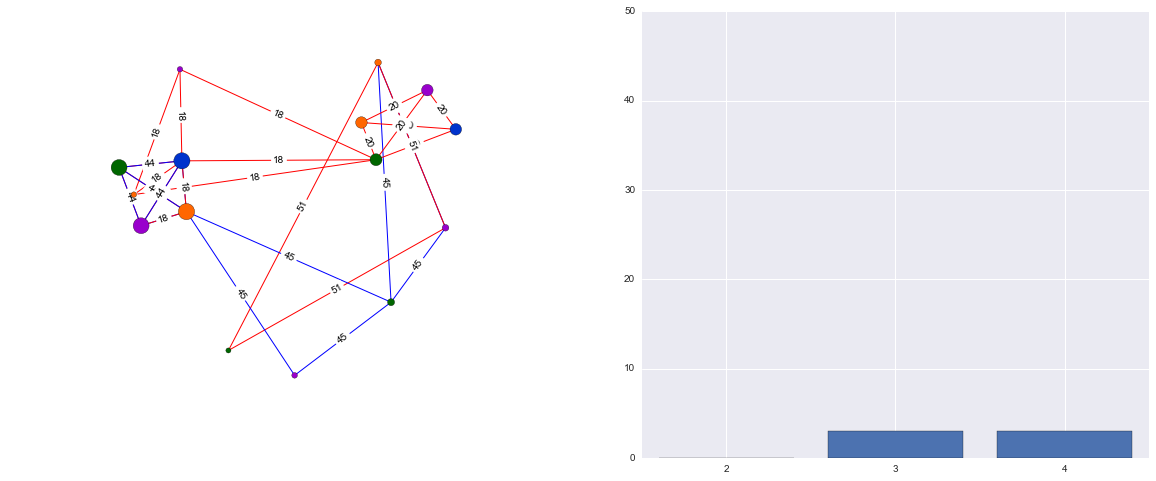

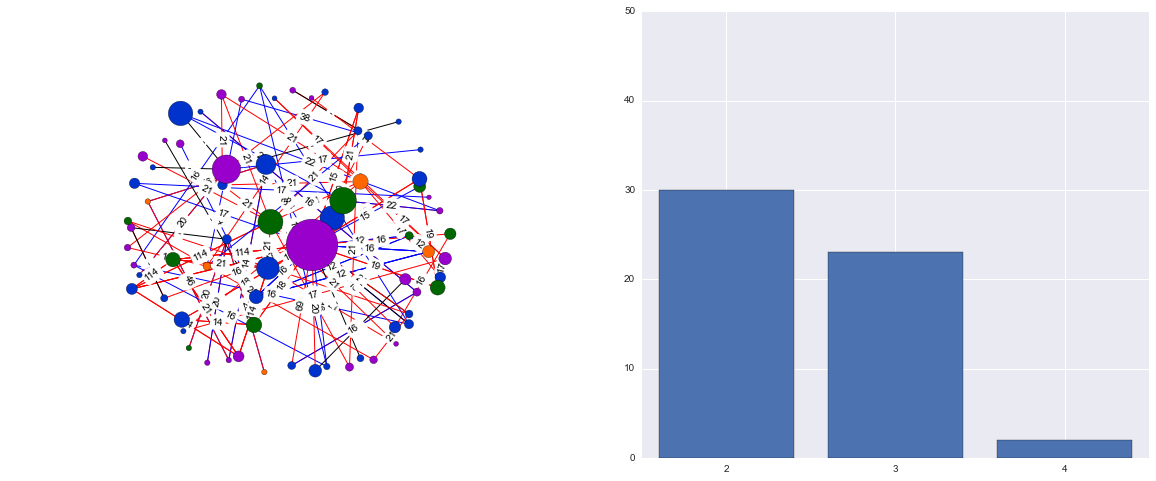

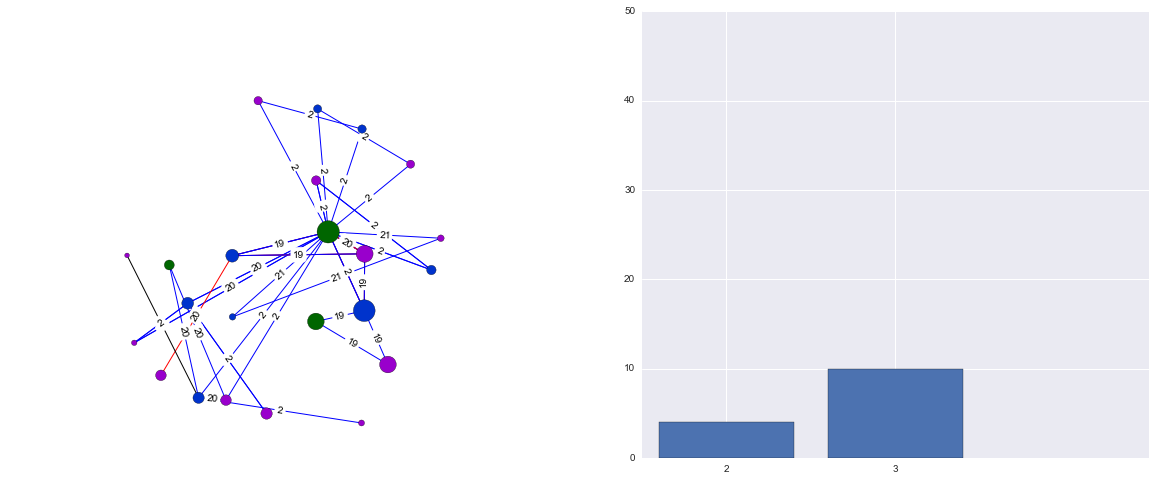

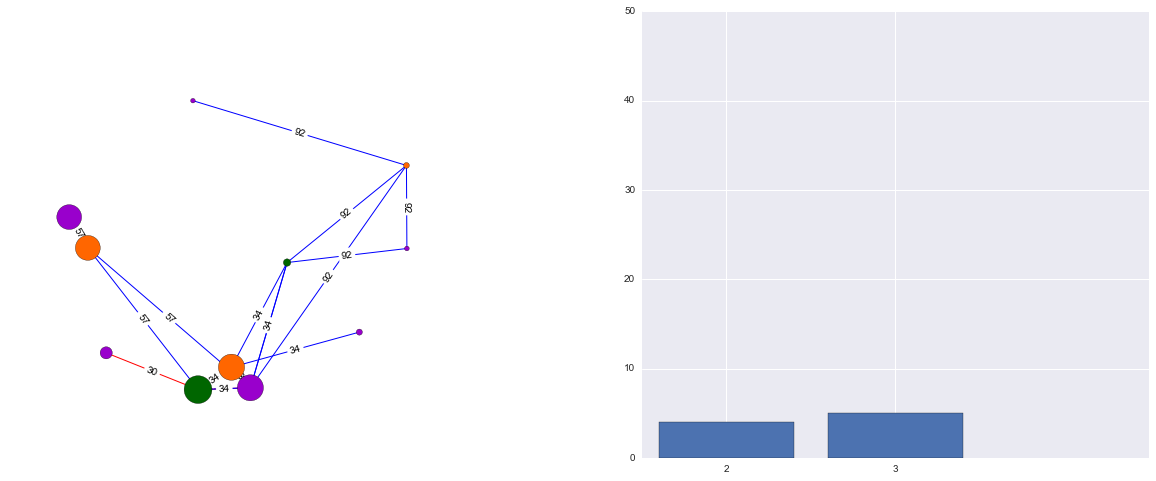

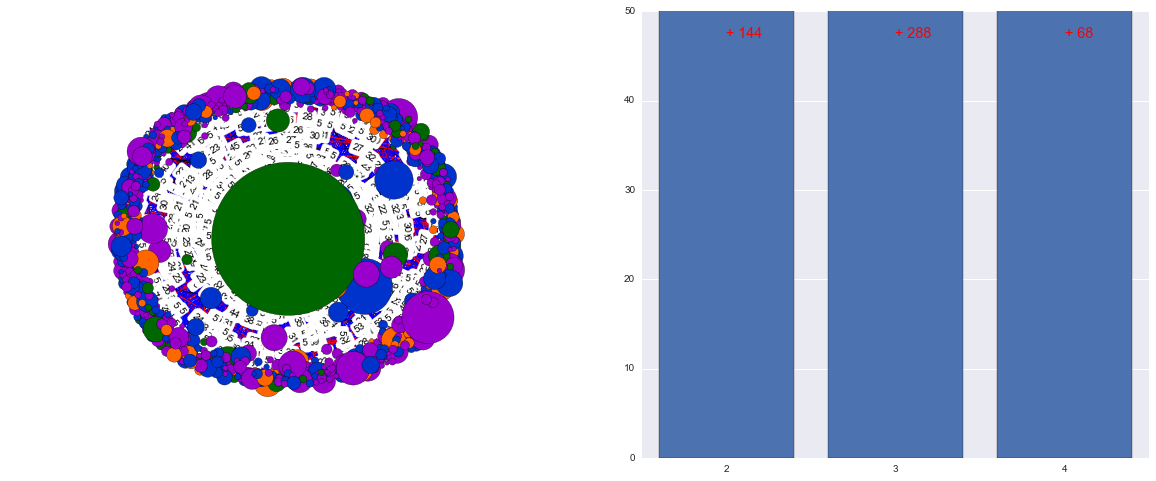

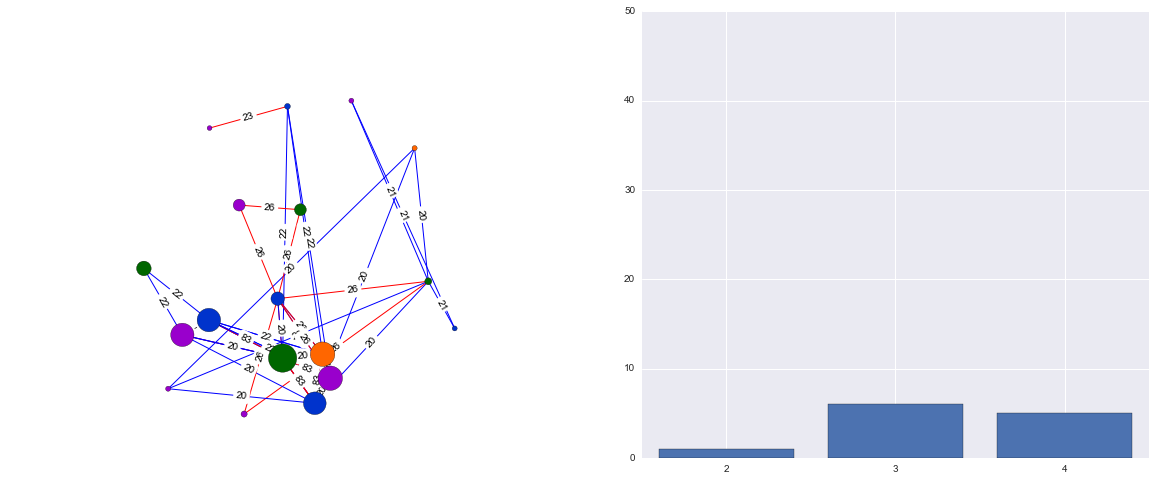

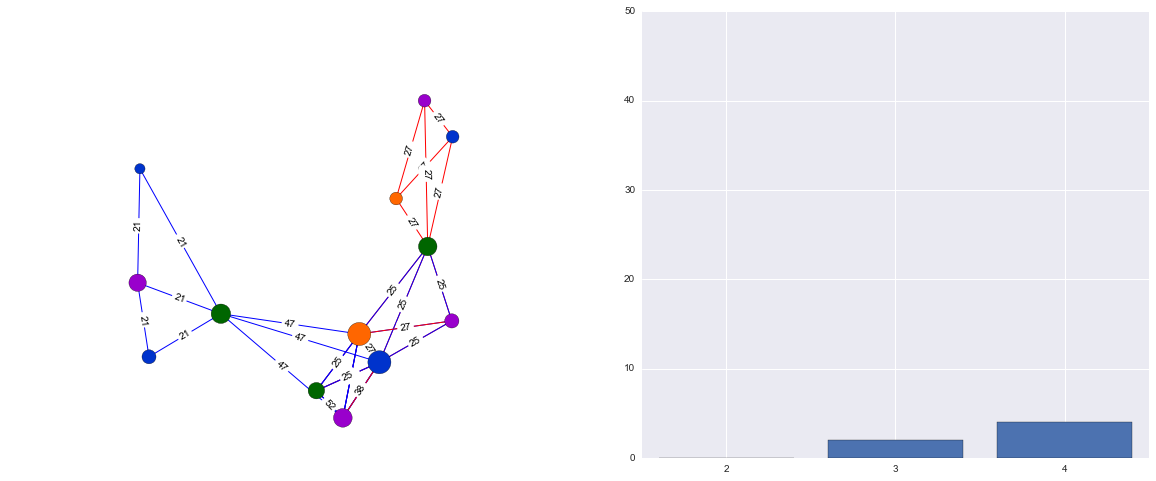

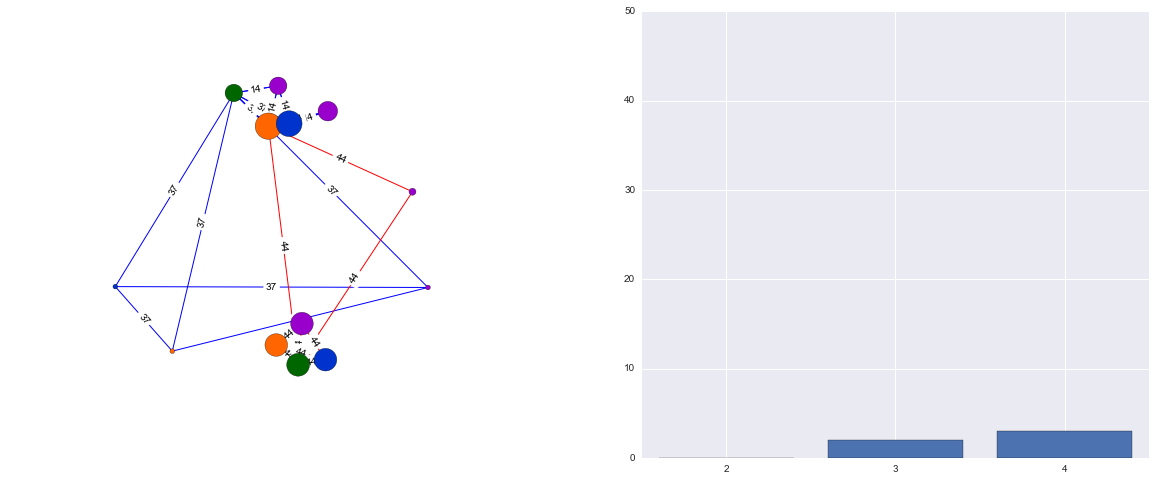

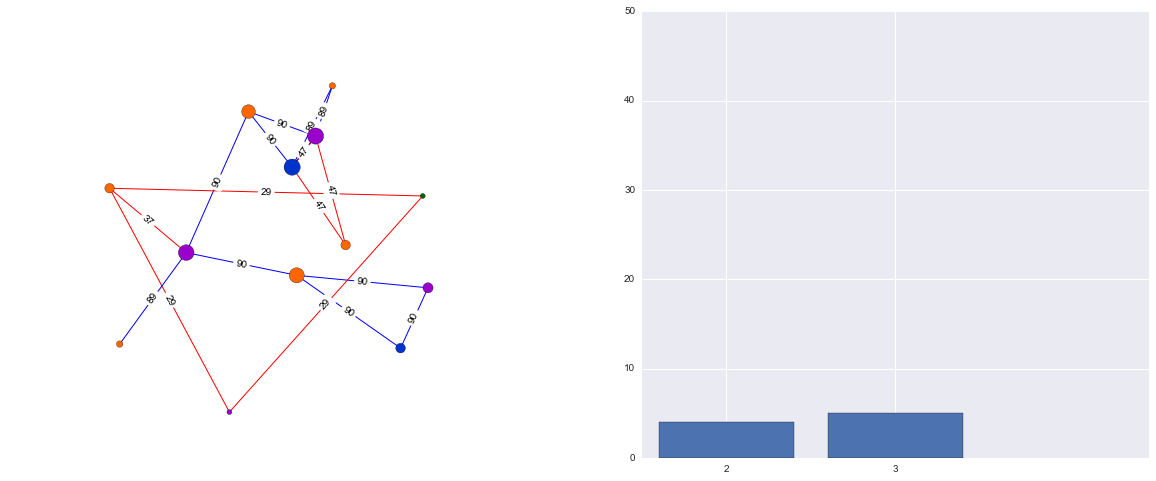

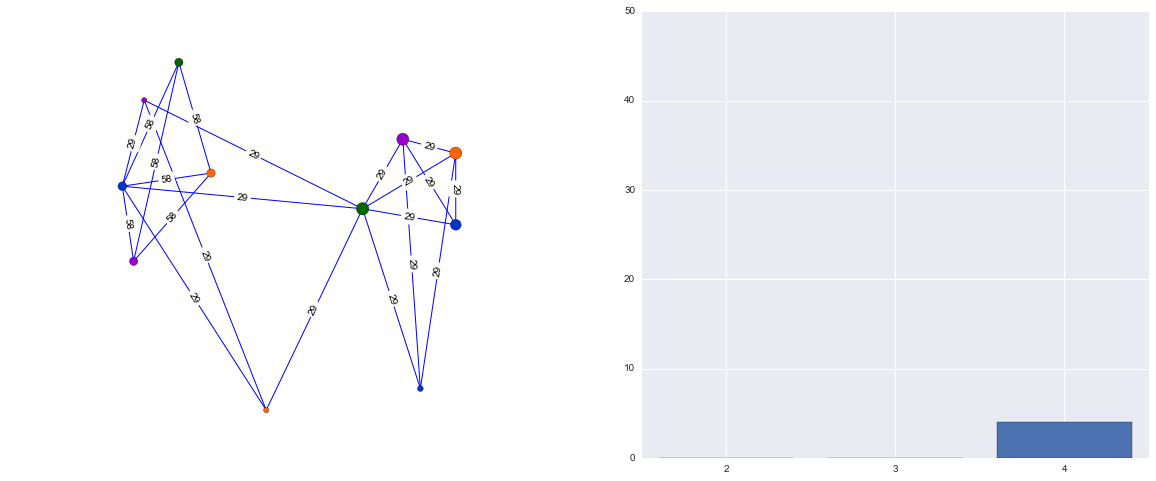

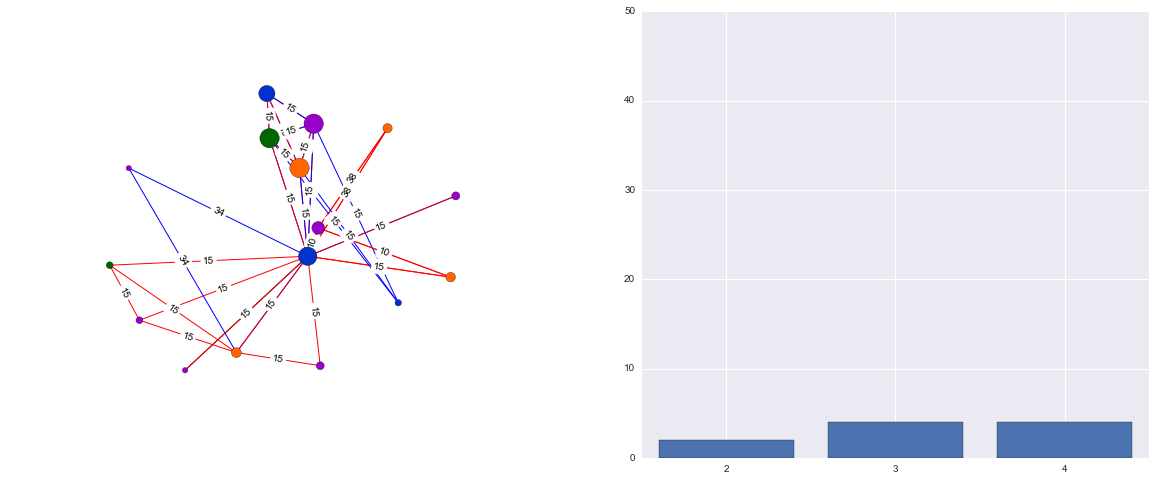

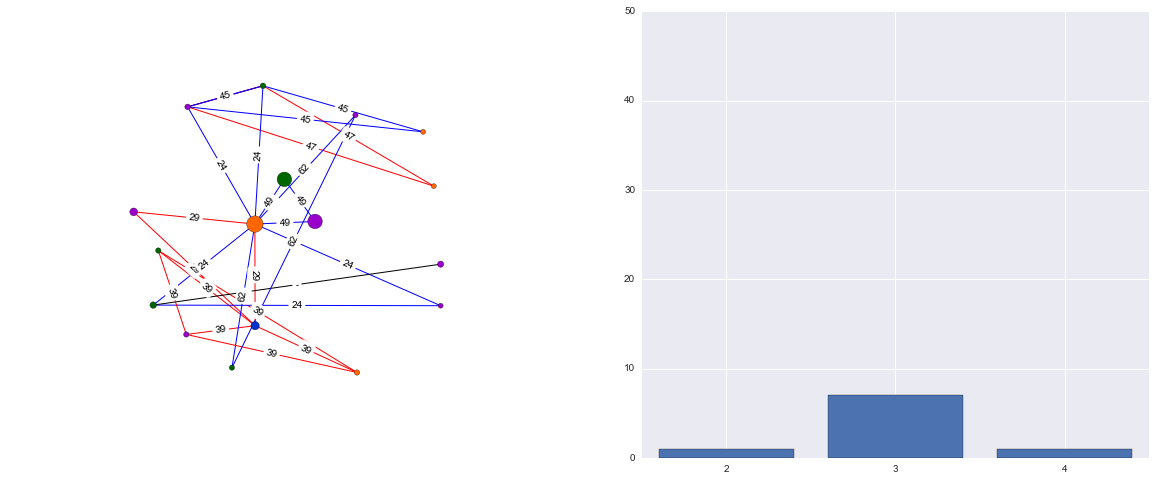

In [4]:
MAX_BAR_HEIGHT = 50
BAR_WIDTH = 0.8

for k, graph in enumerate(graphs):    
    pl.figure(figsize=(20, 8))
    
    pl.subplot(1, 2, 1)    
    
    uid_colors = {'vid': '#9900CC', 'email': '#006600', 'okid': '#FF6600', 'vkid': '#0033CC'}
    node_colors = [uid_colors[d['uid_type']] for n, d in graph.nodes(data=True)]
    node_sizes = [20 + d.get('hit_count', 10) for n, d in graph.nodes(data=True)]
    
    gender_colors = {True: 'blue', False: 'red', '-': 'black'}
    edge_colors = [gender_colors[d['gender']] for a, b, d in graph.edges(data=True)]    
    edge_labels = dict(((a, b), str(d['age'])) for a, b, d in graph.edges(data=True))

    pos = nx.spring_layout(graph, weight='hit_count', k=5, iterations=50)
    nx.draw(graph, pos=pos, node_color=node_colors, edge_color=edge_colors, node_size=node_sizes)
    nx.draw_networkx_edge_labels(graph, pos, edge_labels)
#     nx.draw_networkx_labels(graph, dict((n, (p1*1.1, p2)) for n, (p1, p2) in pos.items()), dict((n, n) for n in graph.nodes()))
    
    pl.subplot(1, 2, 2)
    
    counts = [len(clique) for clique in nx.find_cliques(graph)]
    bc = np.bincount(counts)    
    pl.bar(np.arange(2, len(bc)) - BAR_WIDTH / 2, bc[2:], width=BAR_WIDTH)
    for i, cnt in enumerate(bc):
        if cnt > MAX_BAR_HEIGHT:
            pl.annotate('+ %d' % (cnt - MAX_BAR_HEIGHT), xy=(i, MAX_BAR_HEIGHT - 3), color='r', size='x-large')
    
    pl.ylim(0, MAX_BAR_HEIGHT)
    pl.xlim(1.5, max(5, len(bc)) - 0.5)
    pl.xticks(range(2, max(4, len(bc))))

    pl.savefig("img/graph_%s.png" % k)
#     nx.write_gexf(graph, "img/graph_%s.gexf" % k)